# Rethinking Statistics course in Numpyro - Week 2

Lecture 3: Geocentric Models

- [Video](https://youtu.be/h5aPo5wXN8E)
- [Slides](https://speakerdeck.com/rmcelreath/l03-statistical-rethinking-winter-2019)

Lecture 4: Wiggly Orbits

- [Video](https://youtu.be/ENxTrFf9a7c)
- [Slides](https://speakerdeck.com/rmcelreath/l04-statistical-rethinking-winter-2019)

[Proposed problems](https://github.com/gbosquechacon/statrethinking_winter2019/blob/master/homework/week02.pdf) and [solutions in R](https://github.com/gbosquechacon/statrethinking_winter2019/blob/master/homework/week02_solutions.pdf) for the exercises of the week.

In [138]:
import os
import warnings
warnings.filterwarnings('ignore')

import arviz as az
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as clr

import seaborn as sns
import pandas as pd
from scipy.interpolate import BSpline
from scipy.stats import gaussian_kde
import numpy as np
from scipy import stats

import jax.numpy as jnp
from jax import random, vmap

import numpyro
import numpyro.distributions as dist
import numpyro.optim as optim
from numpyro.diagnostics import hpdi, print_summary
from numpyro.infer import MCMC, NUTS, Predictive, SVI, Trace_ELBO, init_to_value
from numpyro.infer.autoguide import AutoLaplaceApproximation

if "SVG" in os.environ:
    %config InlineBackend.figure_formats = ["svg"]
warnings.formatwarning = lambda message, category, *args, **kwargs: "{}: {}\n".format(
    category.__name__, message
)

from matplotlib import font_manager
from cycler import cycler

font_dirs = ['/Users/zaira/miniconda3/envs/StatRethink/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/barbie.ttf']
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)
    
barbie_theme_colors = {
  "text": '#a62675ff',
  "panel": '#fdf6faff',
  "border": '#d74ea2ff',
  "lighter": '#f5d1e6ff',
  "light": '#eeb4d7ff',
  "medium": '#d74ea2ff',
  "dark": '#bf2986ff',
  "low": '#eeb4d7ff',
  "high": '#bf2986ff'
}

cmap = clr.LinearSegmentedColormap.from_list('barbie', [barbie_theme_colors['low'], barbie_theme_colors['high']], N=256)
# mpl.colormaps.register(cmap)

plt.rcParams.update({
  "axes.prop_cycle": cycler('color', [barbie_theme_colors['dark'], barbie_theme_colors['medium'], barbie_theme_colors['light']]),
  "axes.edgecolor": barbie_theme_colors['border'], 
  "axes.facecolor": barbie_theme_colors['lighter'], 
  "axes.labelcolor": barbie_theme_colors['text'], 
  "axes.labelsize": 13, 
  "axes.linewidth": 2,
  "axes.titlecolor": barbie_theme_colors['text'], 
  "axes.titlesize": 17,
  "axes.spines.right": True,
  "axes.spines.top": True,
  "font.family": "barbie",
  "text.color": barbie_theme_colors['text'],
  "xtick.color": barbie_theme_colors['text'],
  "ytick.color": barbie_theme_colors['text'],
  "image.cmap": 'barbie',
  "lines.color": barbie_theme_colors['dark'],
  "lines.linewidth": 3
  })
mpl.rcParams['axes.unicode_minus'] = False
numpyro.set_platform("cpu")


In [13]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Thu Nov 23 2023

Python implementation: CPython
Python version       : 3.9.18
IPython version      : 8.17.2

numpyro   : 0.13.2
scipy     : 1.11.3
jax       : 0.4.19
pandas    : 2.1.3
numpy     : 1.26.2
seaborn   : 0.12.2
arviz     : 0.16.1
matplotlib: 3.8.0

Watermark: 2.4.3



In [14]:
rng_key = random.PRNGKey(0)

## Chapter code

### Code 4.1
Simulate random walks on the soccer field that converges to a noral distribution:

In [15]:
pos = jnp.sum(dist.Uniform(-1, 1).sample(random.PRNGKey(0), (1000, 16)), -1) # -1 counts from the last (16) to the first (1000) axis
pos.shape

(1000,)

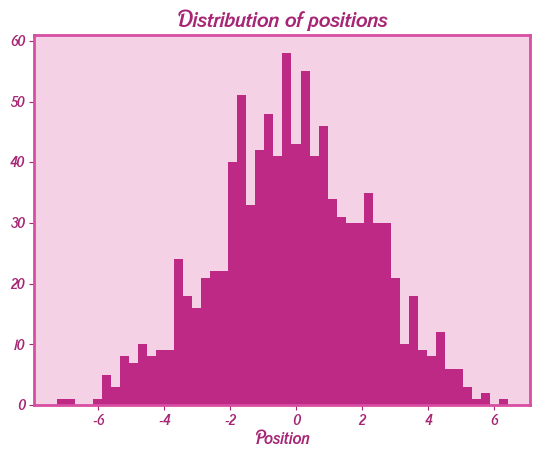

In [16]:
plt.hist(pos, bins=50)
plt.title("Distribution of positions")
plt.xlabel("Position");

### Code 4.2


In [17]:
jnp.prod(1 + dist.Uniform(0, 0.1).sample(random.PRNGKey(0), (12,)))

Array(1.7294353, dtype=float32)

### Code 4.3
Let's sample 1000 random growth rates and check how when effects are small and they multiply, the resultant distribution is also normal:

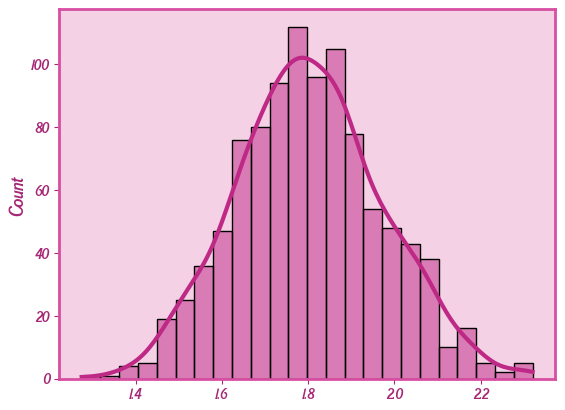

In [18]:
growth = jnp.prod(1 + dist.Uniform(0, 0.1).sample(random.PRNGKey(0), (1000, 12)), -1)
sns.histplot(growth, kde=True);

### Code 4.4
When small effects multiply, they are distributed normally; however, if the effects are large, they are not distributed normally:

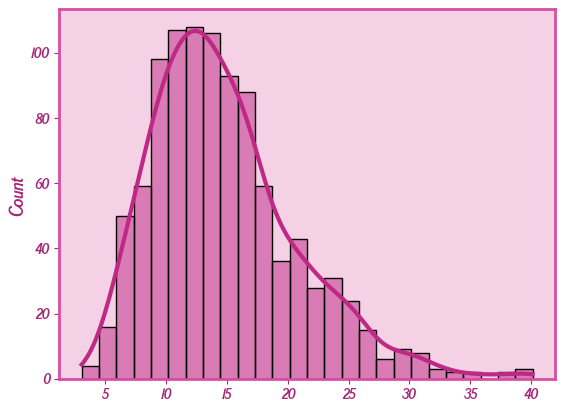

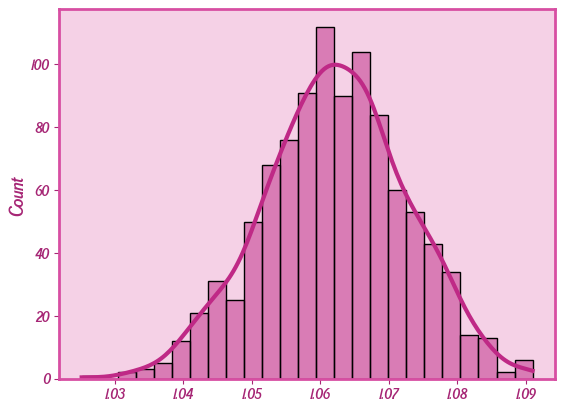

In [19]:
big = jnp.prod(1 + dist.Uniform(0, 0.5).sample(random.PRNGKey(0), (1000, 12)), -1)
small = jnp.prod(1 + dist.Uniform(0, 0.01).sample(random.PRNGKey(0), (1000, 12)), -1)
sns.histplot(big, kde=True)
plt.show()
sns.histplot(small, kde=True);

### Code 4.5
However, multiplied large effects are normal on the log-scale:

<Axes: ylabel='Count'>

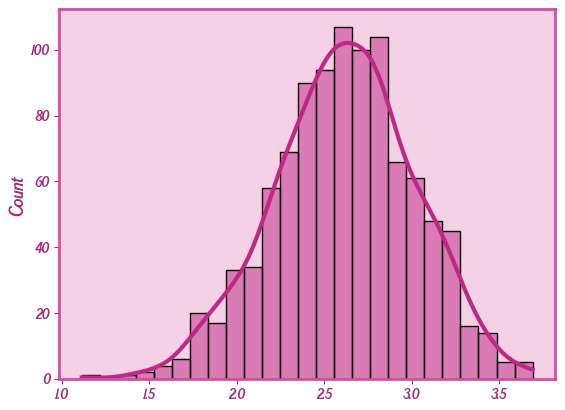

In [20]:
log_big = jnp.log(jnp.prod(1 + dist.Uniform(0, 0.5).sample(random.PRNGKey(0), (1000, 12)), -1))
sns.histplot(log_big, kde=True)

### Code 4.6
The Bayes theorem:

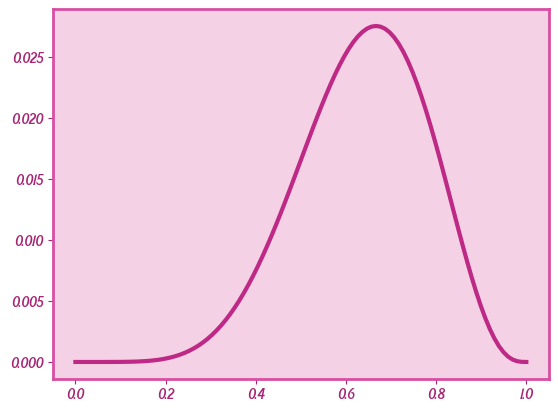

In [21]:
w = 6
n = 9
p_grid = jnp.linspace(0, 1, 100)
posterior = jnp.exp(dist.Binomial(n, p_grid).log_prob(w)) * jnp.exp(dist.Uniform(0, 1).log_prob(p_grid))
posterior = posterior / jnp.sum(posterior)
plt.plot(p_grid, posterior)

### Code 4.7

In [22]:
d = pd.read_csv('data/Howell1.csv', sep=';')
d.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


### Code 4.9

In [23]:
d.describe()

,height,weight,age,male
count,544.000000,544.000000,544.000000,544.000000
mean,138.263596,35.610618,29.344393,0.472426
std,27.602448,14.719178,20.746888,0.499699
min,53.975000,4.252425,0.000000,0.000000
25%,125.095000,22.007717,12.000000,0.000000
50%,148.590000,40.057844,27.000000,0.000000
75%,157.480000,47.209005,43.000000,1.000000
max,179.070000,62.992589,88.000000,1.000000


### Code 4.11
Let's take adults only, as for them weight ~ linear f(height).

In [24]:
d2 = d.loc[d['age'] >= 18,]
d2.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


<Axes: xlabel='height', ylabel='Count'>

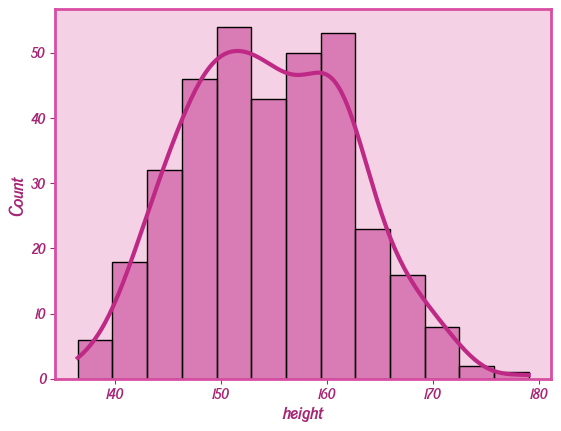

In [25]:
sns.histplot(d2.height, kde=True)

### Code 4.12
Let's plot our prior for mu:

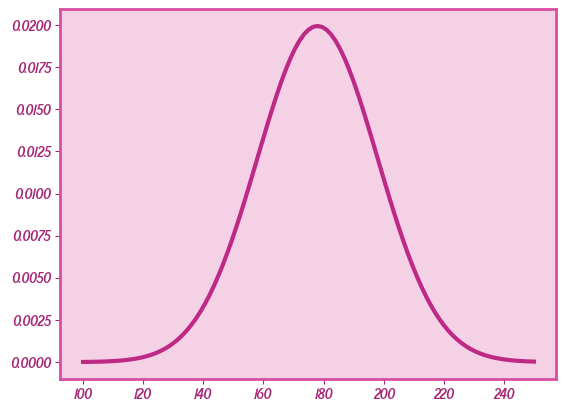

In [26]:
x = jnp.linspace(100, 250, 101)
plt.plot(x, jnp.exp(dist.Normal(178, 20).log_prob(x)))

### Code 4.13
And for sigma:

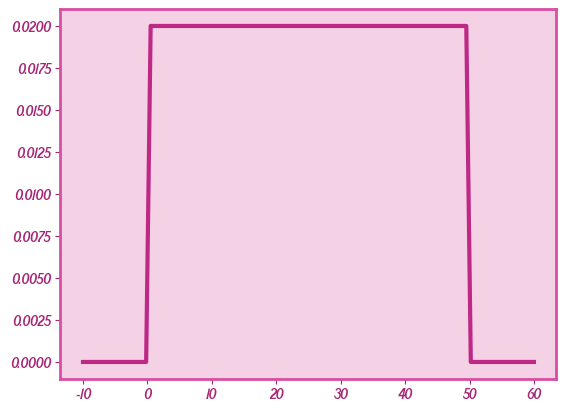

In [27]:
x = jnp.linspace(-10, 60, 101)
plt.plot(x, jnp.exp(dist.Uniform(0, 50, validate_args=True).log_prob(x)))

### Code 4.14
Now we can look at the prior for heights just by sampling from other priors:

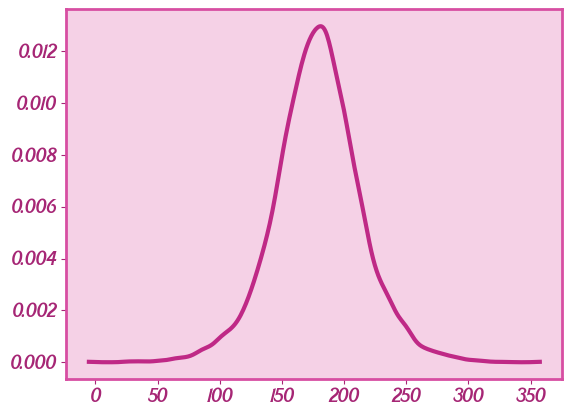

In [28]:
sample_mu = dist.Normal(178, 20).sample(random.PRNGKey(0), (int(1e4),))
sample_sigma = dist.Uniform(0, 50).sample(random.PRNGKey(1), (int(1e4),))
prior_h = dist.Normal(sample_mu, sample_sigma).sample(random.PRNGKey(2))

az.plot_kde(prior_h)
plt.show()

### Code 4.15
If we take a flatter prior, distribution for heights stops making sense as people get too tall and have negative height.

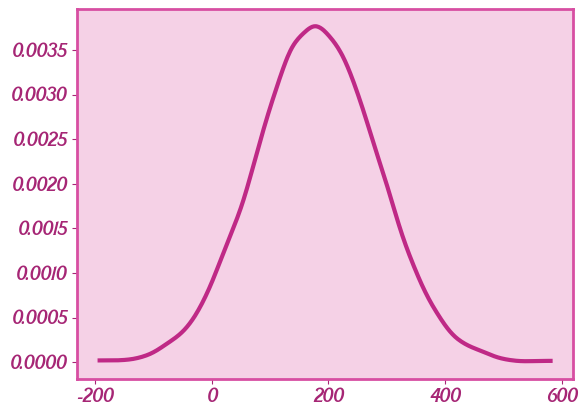

In [29]:
sample_mu = dist.Normal(178, 100).sample(random.PRNGKey(0), (int(1e4),))
prior_h = dist.Normal(sample_mu, sample_sigma).sample(random.PRNGKey(2))

az.plot_kde(prior_h)
plt.show()

### Code 4.16
Now let's use grid approximation to compute posterior distributions:

In [30]:
mu_list = jnp.linspace(150, 160, 100)
sigma_list = jnp.linspace(7, 9, 100)
mesh = jnp.meshgrid(mu_list, sigma_list)
post = {"mu": mesh[0].reshape(-1), "sigma": mesh[1].reshape(-1)}
post['LL'] = vmap(
    lambda mu, sigma: jnp.sum(dist.Normal(mu, sigma).log_prob(d2.height.values))
)(post["mu"], post["sigma"])
logprob_mu = dist.Normal(178, 20).log_prob(post["mu"])
logprob_sigma = dist.Uniform(0, 50).log_prob(post["sigma"])
post["prob"] = post["LL"] + logprob_mu + logprob_sigma
post["prob"] = jnp.exp(post["prob"] - jnp.max(post["prob"]))

### Code 4.17

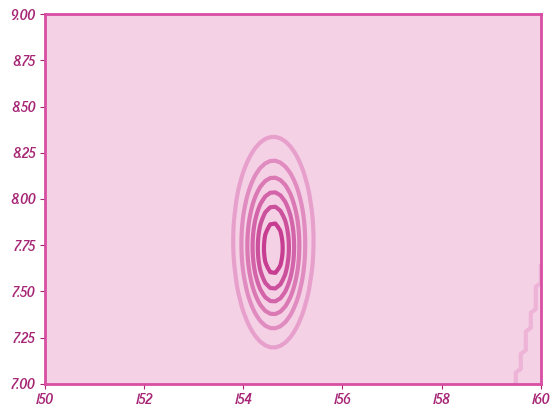

In [31]:
plt.contour(
    post["mu"].reshape(100, 100),
    post["sigma"].reshape(100, 100),
    post["prob"].reshape(100, 100),
)
plt.show()

### Code 4.18

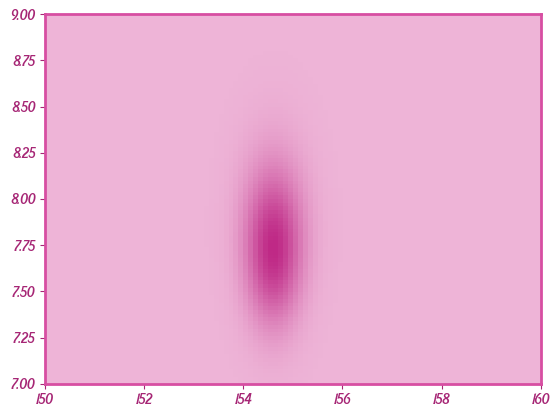

In [32]:
plt.imshow(
    post["prob"].reshape(100, 100),
    origin="lower",
    extent=(150, 160, 7, 9),
    aspect="auto",
)
plt.show()

### Code 4.19
To explore the posterior in more detail, let's sample from it:

In [33]:
prob = post["prob"] / jnp.sum(post["prob"])
sample_rows = dist.Categorical(probs=prob).sample(random.PRNGKey(0), (int(1e4),)) # ? indeces with prob ~ prob?
sample_mu = post["mu"][sample_rows]
sample_sigma = post["sigma"][sample_rows]

### Code 4.20

<Axes: >

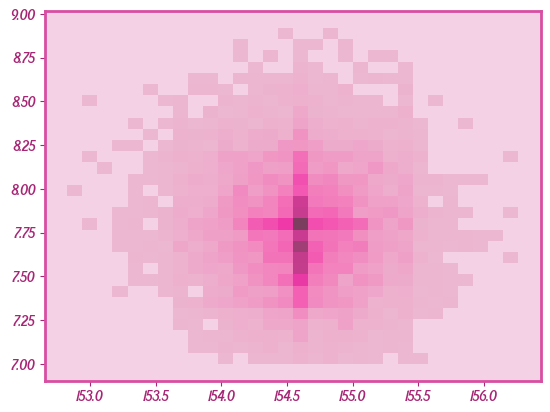

In [34]:
sns.histplot(x=sample_mu, y=sample_sigma, bins=(30, 30))

### Code 4.21
Let's plot marginal posterior densities of the two parameters

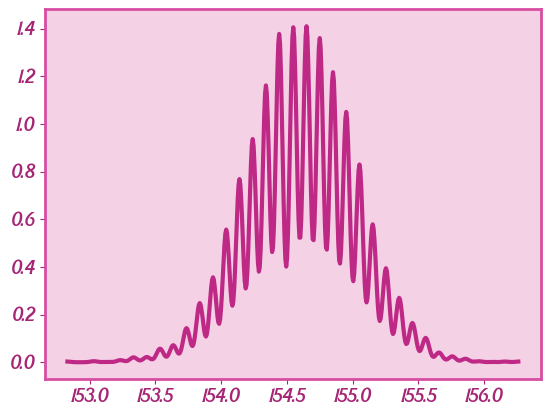

<Axes: >

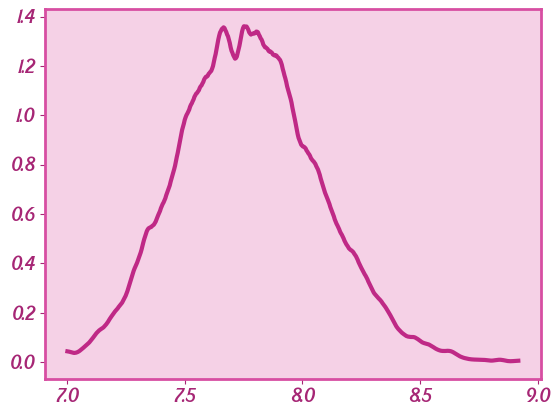

In [35]:
az.plot_kde(sample_mu)
plt.show()
az.plot_kde(sample_sigma)

### Code 4.22
We can also summarise the widths of the densities with HPDI:

In [36]:
print(numpyro.diagnostics.hpdi(sample_mu, 0.89))
print(numpyro.diagnostics.hpdi(sample_sigma, 0.89))

[153.93939 155.15152]
[7.3232327 8.252525 ]


### Code 4.23
The standard deviation will not be always normal in the posterior. It will heavily depend on the sample size. Let's now repeat the analysis with only 20 samples to reveal this issue.

In [37]:
d3 = d2['height'].sample(20)

### Code 4.24
Let's explore the marginal posterior distribution for sigma, which will now have a long tail:

Text(0, 0.5, 'sampled sigma')

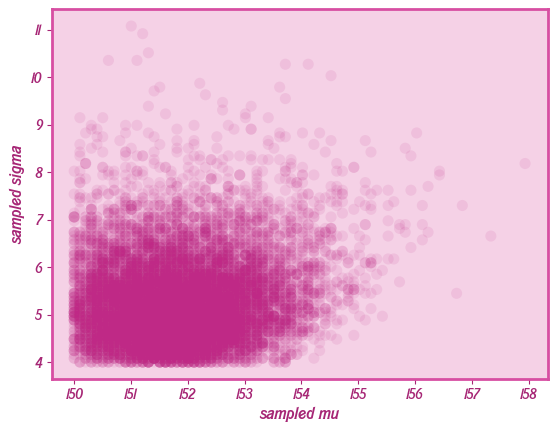

In [38]:
mu_list = jnp.linspace(start=150, stop=170, num=200)
sigma_list = jnp.linspace(start=4, stop=20, num=200)
mesh = jnp.meshgrid(mu_list, sigma_list)
post2 = {"mu": mesh[0].reshape(-1), "sigma": mesh[1].reshape(-1)}
post2["LL"] = vmap(
    lambda mu, sigma: jnp.sum(dist.Normal(mu, sigma).log_prob(d3.values))
)(post2["mu"], post2["sigma"])
logprob_mu = dist.Normal(178, 20).log_prob(post2["mu"])
logprob_sigma = dist.Uniform(0, 50).log_prob(post2["sigma"])
post2["prob"] = post2["LL"] + logprob_mu + logprob_sigma
post2["prob"] = jnp.exp(post2["prob"] - jnp.max(post2["prob"])) # ???
prob = post2["prob"] / jnp.sum(post2["prob"])
sample2_rows = dist.Categorical(probs=prob).sample(random.PRNGKey(0), (int(1e4),))
sample2_mu = post2["mu"][sample2_rows]
sample2_sigma = post2["sigma"][sample2_rows]
sns.scatterplot(x=sample2_mu, y=sample2_sigma, s=64, alpha=0.1, edgecolor="none")
plt.xlabel('sampled mu')
plt.ylabel('sampled sigma')

### Code 4.25

<Axes: ylabel='Count'>

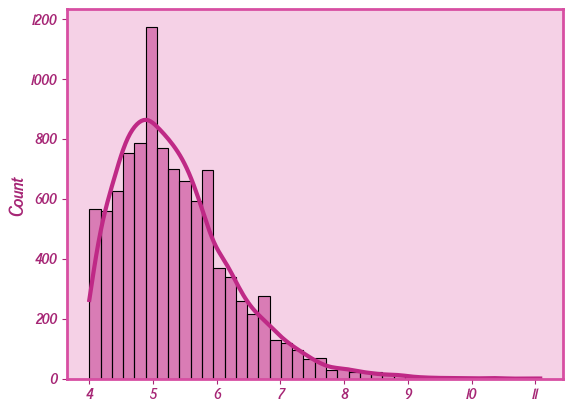

In [39]:
sns.histplot(sample2_sigma, bins=40, kde=True)

### Code 4.27
Let's define the model:
$$h_i \sim Normal(µ, σ)$$
$$µ \sim Normal(178, 20)$$
$$σ \sim Uniform(0,50)$$

In [40]:
def flist(height):
    mu = numpyro.sample("mu", dist.Normal(178, 20))                 # same as dist.Distribution().sample()?
    sigma = numpyro.sample("sigma", dist.Uniform(0, 50))
    numpyro.sample("height", dist.Normal(mu, sigma), obs=height)    # whats happening here? we sample from N(µ, σ), why obs?

### Code 4.28
Now we perform quadratic approximation to fit the model and obtain the posterior:

In [41]:
m4_1 = AutoLaplaceApproximation(flist)
svi = SVI(flist, m4_1, optim.Adam(1), Trace_ELBO(), height=d2.height.values) # wtf is happening here
svi_result = svi.run(random.PRNGKey(0), 2000)
p4_1 = svi_result.params

100%|██████████| 2000/2000 [00:00<00:00, 9162.42it/s, init loss: 4000.1150, avg. loss [1901-2000]: 1226.0389]


### Code 4.29
Now let's sample from the posterior to summarise it:

In [42]:
samples = m4_1.sample_posterior(random.PRNGKey(1), p4_1, (1000,))
print_summary(samples, 0.89, group_by_chain=False)
print_summary({"mu": sample2_mu, "sigma": sample2_sigma}, 0.89, group_by_chain=False)


                mean       std    median      5.5%     94.5%     n_eff     r_hat
        mu    154.60      0.40    154.60    154.00    155.28    995.05      1.00
     sigma      7.76      0.30      7.76      7.33      8.26   1007.15      1.00


                mean       std    median      5.5%     94.5%     n_eff     r_hat
        mu    151.91      1.07    151.81    150.30    153.52   9598.42      1.00
     sigma      5.35      0.91      5.21      4.00      6.49   9940.27      1.00



### Code 4.30
We can also give the quadratic approximation a starting position:

In [43]:
start = {"mu": d2.height.mean(), "sigma": d2.height.std()}
m4_1 = AutoLaplaceApproximation(flist, init_loc_fn=init_to_value(values=start))
svi = SVI(flist, m4_1, optim.Adam(0.1), Trace_ELBO(), height=d2.height.values)
svi_result = svi.run(random.PRNGKey(0), 2000)
p4_1 = svi_result.params
samples = m4_1.sample_posterior(random.PRNGKey(1), p4_1, (1000,))
print_summary(samples, 0.89, group_by_chain=False)


100%|██████████| 2000/2000 [00:00<00:00, 9651.35it/s, init loss: 1226.0387, avg. loss [1901-2000]: 1226.0389]



                mean       std    median      5.5%     94.5%     n_eff     r_hat
        mu    154.59      0.40    154.59    153.99    155.28    995.05      1.00
     sigma      7.76      0.30      7.76      7.33      8.26   1007.04      1.00



### Code 4.31
Let's use a narrower prior for mu:

In [44]:
def model(height):
    mu = numpyro.sample("mu", dist.Normal(178, 0.1))                 
    sigma = numpyro.sample("sigma", dist.Uniform(0, 50))
    numpyro.sample("height", dist.Normal(mu, sigma), obs=height)    
    
m4_2 = AutoLaplaceApproximation(model)
svi = SVI(model, m4_2, optim.Adam(1), Trace_ELBO(), height=d2.height.values) 
svi_result = svi.run(random.PRNGKey(0), 2000)
p4_2 = svi_result.params
samples = m4_2.sample_posterior(random.PRNGKey(1), p4_2, (1000,))
print_summary(samples, 0.89, group_by_chain=False)

100%|██████████| 2000/2000 [00:00<00:00, 9516.43it/s, init loss: 1584193.6250, avg. loss [1901-2000]: 1626.5830]



                mean       std    median      5.5%     94.5%     n_eff     r_hat
        mu    177.86      0.10    177.86    177.72    178.03    995.05      1.00
     sigma     24.57      0.94     24.60     23.01     25.96   1012.88      1.00



### Code 4.32
We can see the matrix of variances and covariances:

In [45]:
samples = m4_1.sample_posterior(random.PRNGKey(1), p4_1, (1000,))
vcov = jnp.cov(jnp.stack(list(samples.values()), axis=0))
vcov

Array([[0.16249587, 0.00154646],
       [0.00154646, 0.08733496]], dtype=float32)

### Code 4.33
And separate it into a vector of variences for the parameters and a correlation matrix between them:

In [46]:
print(jnp.diagonal(vcov))
print(vcov / jnp.sqrt(jnp.outer(jnp.diagonal(vcov), jnp.diagonal(vcov))))

[0.16249587 0.08733496]
[[1.         0.01298147]
 [0.01298147 1.        ]]


### Code 4.34
Let's now sample the posterior:

In [47]:
post = m4_1.sample_posterior(random.PRNGKey(1), p4_1, (int(1e4),))
{latent: list(post[latent][:6]) for latent in post}

{'mu': [Array(154.2356, dtype=float32),
  Array(154.47672, dtype=float32),
  Array(154.97047, dtype=float32),
  Array(154.20374, dtype=float32),
  Array(155.48271, dtype=float32),
  Array(154.81831, dtype=float32)],
 'sigma': [Array(7.5602665, dtype=float32),
  Array(7.306454, dtype=float32),
  Array(7.27963, dtype=float32),
  Array(7.8118353, dtype=float32),
  Array(7.9042172, dtype=float32),
  Array(7.978001, dtype=float32)]}

### Code 4.35

In [48]:
print_summary(post, 0.89, False)


                mean       std    median      5.5%     94.5%     n_eff     r_hat
        mu    154.60      0.41    154.60    153.93    155.24   9926.99      1.00
     sigma      7.75      0.29      7.74      7.29      8.23   9502.45      1.00



<Axes: >

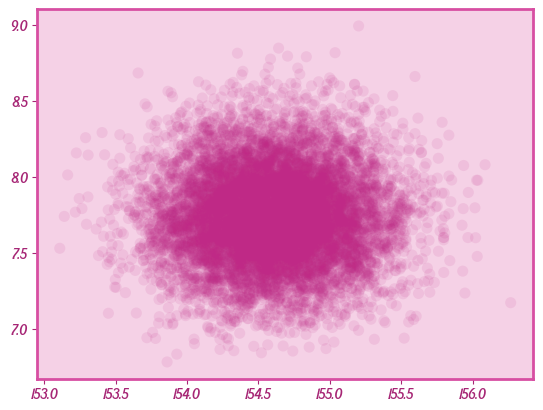

In [49]:
sns.scatterplot(x=post['mu'], y=post['sigma'], s=64, alpha=0.1, edgecolor="none")

### Code 4.37
If we plot weight vs height, we see that the relationship is linear.
So let's define a linear model:
$$h_i \sim Normal(µ_i, σ)$$
$$µ = \alpha + \beta(x_i - \=x) $$
$$\alpha \sim Normal(178, 20)$$
$$\beta \sim Normal(0,10)$$
$$σ \sim Uniform(0,50)$$

<Axes: xlabel='weight', ylabel='height'>

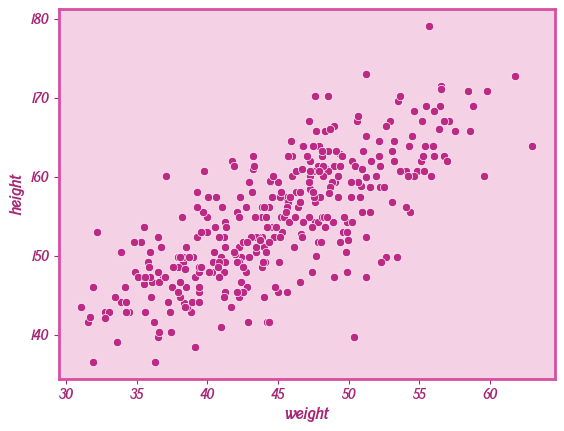

In [50]:
sns.scatterplot(x=d2.weight, y=d2.height)

### Code 4.38
Let's simulate a bunch of lines:

In [51]:
with numpyro.handlers.seed(rng_seed=2971):
    N = 100                                                     # 100 lines
    a = numpyro.sample("a", dist.Normal(178, 20).expand([N]))
    b = numpyro.sample("b", dist.Normal(0, 10).expand([N]))

### Code 4.39
Let's now plot the prior lines:

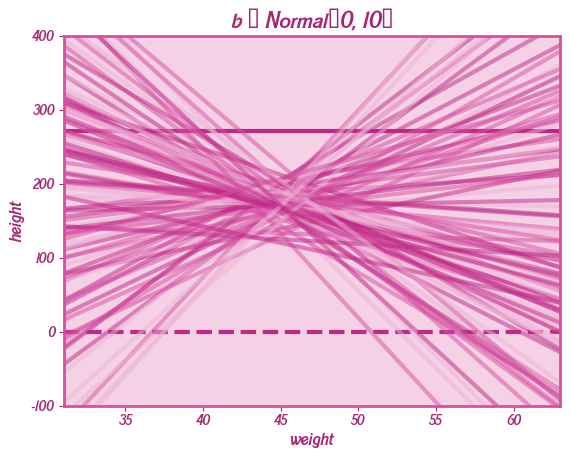

In [52]:
plt.subplot(
    xlim=(d2.weight.min(), d2.weight.max()),
    ylim=(-100, 400),
    xlabel="weight",
    ylabel="height",
)
plt.axhline(y=0, ls="--")
plt.axhline(y=272,  ls="-")
plt.title("b ~ Normal(0, 10)")
xbar = d2.weight.mean()
x = jnp.linspace(d2.weight.min(), d2.weight.max(), 101)
for i in range(N):
    plt.plot(x, a[i] + b[i] * (x - xbar),  alpha=0.5)
plt.show()

### Code 4.40
As the lines make no sense, we can do better immediately by making beta distrivuted log-normally:

<Axes: ylabel='Count'>

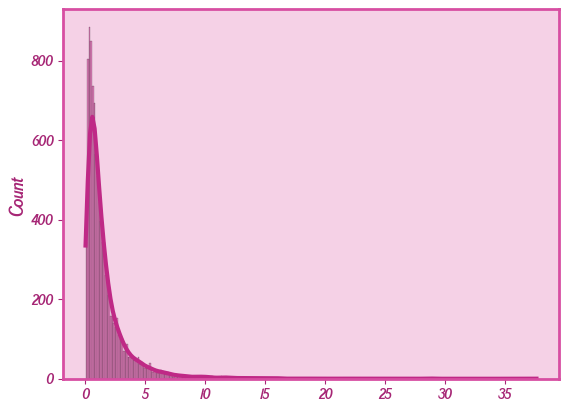

In [53]:
b = dist.LogNormal(0, 1).sample(random.PRNGKey(0), (int(1e4),))
sns.histplot(b, kde=True)

### Code 4.41

In [54]:
with numpyro.handlers.seed(rng_seed=2971):
    N = 100                                                     # 100 lines
    a = numpyro.sample("a", dist.Normal(178, 20).expand([N]))
    b = numpyro.sample("b", dist.LogNormal(0, 1).expand([N]))

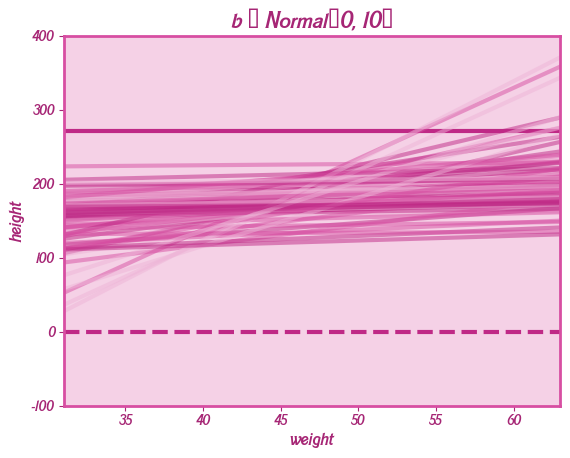

In [55]:
plt.subplot(
    xlim=(d2.weight.min(), d2.weight.max()),
    ylim=(-100, 400),
    xlabel="weight",
    ylabel="height",
)
plt.axhline(y=0, ls="--")
plt.axhline(y=272,  ls="-")
plt.title("b ~ Normal(0, 10)")
xbar = d2.weight.mean()
x = jnp.linspace(d2.weight.min(), d2.weight.max(), 101)
for i in range(N):
    plt.plot(x, a[i] + b[i] * (x - xbar),  alpha=0.5)
plt.show()

### Code 4.42
Let's fit the model and obtain the posteriors:

In [56]:
# define the average weight, x-bar
xbar = d2.weight.mean()

# fit model
def model(weight, height):
    a = numpyro.sample("a", dist.Normal(178, 20))
    b = numpyro.sample("b", dist.LogNormal(0, 1))
    sigma = numpyro.sample("sigma", dist.Uniform(0, 50))
    mu = numpyro.deterministic("mu", a + b * (weight - xbar))
    numpyro.sample("height", dist.Normal(mu, sigma), obs=height)    
    
m4_3 = AutoLaplaceApproximation(model)
svi = SVI(
    model, 
    m4_3, 
    optim.Adam(1), 
    Trace_ELBO(), 
    weight=d2.weight.values, 
    height=d2.height.values
    ) 
svi_result = svi.run(random.PRNGKey(0), 2000)
p4_3 = svi_result.params

100%|██████████| 2000/2000 [00:00<00:00, 8582.65it/s, init loss: 40631.5430, avg. loss [1901-2000]: 1078.9297]


### Code 4.43
The same model can also be coded differently:

In [57]:
def model(weight, height):
    a = numpyro.sample("a", dist.Normal(178, 20))
    log_b = numpyro.sample("log_b", dist.Normal(0, 1))
    sigma = numpyro.sample("sigma", dist.Uniform(0, 50))
    mu = numpyro.deterministic("mu", a + jnp.exp(log_b) * (weight - xbar))
    numpyro.sample("height", dist.Normal(mu, sigma), obs=height)    
    
m4_3b = AutoLaplaceApproximation(model)

### Code 4.44

In [58]:
samples = m4_3.sample_posterior(random.PRNGKey(1), p4_3, (1000,))
samples.pop("mu")
print_summary(samples, 0.89, False)


                mean       std    median      5.5%     94.5%     n_eff     r_hat
         a    154.62      0.27    154.63    154.16    155.03    931.50      1.00
         b      0.91      0.04      0.90      0.84      0.97   1083.74      1.00
     sigma      5.08      0.19      5.08      4.79      5.41    949.65      1.00



### Code 4.45

In [59]:
vcov = jnp.cov(jnp.stack(list(samples.values()), axis=0))
pd.DataFrame(jnp.round(vcov, 3), columns=['a', 'b', 'sigma'], index=['a', 'b', 'sigma'])

,a,b,sigma
a,0.075,-0.000,0.001
b,-0.000,0.002,-0.000
sigma,0.001,-0.000,0.038


### Code 4.46
We can now plot the mean fitted line:

<Axes: xlabel='weight', ylabel='height'>

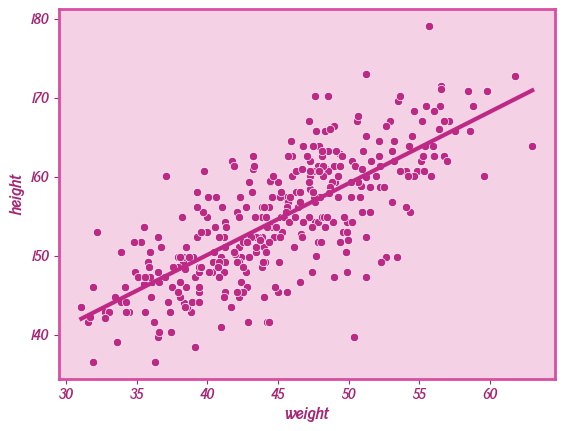

In [60]:
sns.scatterplot(x=d2.weight, y=d2.height, )
post = m4_3.sample_posterior(random.PRNGKey(1), p4_3, (1000,))
a_map = post['a'].mean()
b_map = post['b'].mean()
x = jnp.linspace(d2.weight.min(), d2.weight.max(), 101)
sns.lineplot(x=x, y=a_map + b_map * (x - xbar))

### Code 4.47
Let's sample from the posterior to summarise it:

In [61]:
post = m4_3.sample_posterior(random.PRNGKey(1), p4_3, (1000,))
{latent: list(post[latent].reshape(-1)[:5]) for latent in post}

{'a': [Array(154.36615, dtype=float32),
  Array(154.78511, dtype=float32),
  Array(154.73534, dtype=float32),
  Array(154.53842, dtype=float32),
  Array(154.53549, dtype=float32)],
 'b': [Array(0.97464514, dtype=float32),
  Array(0.89000493, dtype=float32),
  Array(0.8190222, dtype=float32),
  Array(0.8334105, dtype=float32),
  Array(1.0119181, dtype=float32)],
 'mu': [Array(157.12938, dtype=float32),
  Array(146.0771, dtype=float32),
  Array(141.5733, dtype=float32),
  Array(162.21344, dtype=float32),
  Array(150.74669, dtype=float32)],
 'sigma': [Array(4.9764595, dtype=float32),
  Array(4.94353, dtype=float32),
  Array(5.2826037, dtype=float32),
  Array(4.877722, dtype=float32),
  Array(4.89487, dtype=float32)]}

### Code 4.48
Now we can also sample 10 cases and re-estimate the model, so that later we can add data and see how it changes the lines.

In [62]:
N = 10
dN = d2[:N]


def model(weight, height):
    a = numpyro.sample("a", dist.Normal(178, 20))
    b = numpyro.sample("b", dist.LogNormal(0, 1))
    sigma = numpyro.sample("sigma", dist.Uniform(0, 50))
    mu = a + b * (weight - jnp.mean(weight))
    numpyro.sample("height", dist.Normal(mu, sigma), obs=height)


mN = AutoLaplaceApproximation(model)
svi = SVI(
    model,
    mN,
    optim.Adam(1),
    Trace_ELBO(),
    weight=dN.weight.values,
    height=dN.height.values,
)
svi_result = svi.run(random.PRNGKey(0), 1000)
pN = svi_result.params

100%|██████████| 1000/1000 [00:00<00:00, 5434.20it/s, init loss: 1233.4980, avg. loss [951-1000]: 37.0481]


### Code 4.49
Let's plot 20 lines:

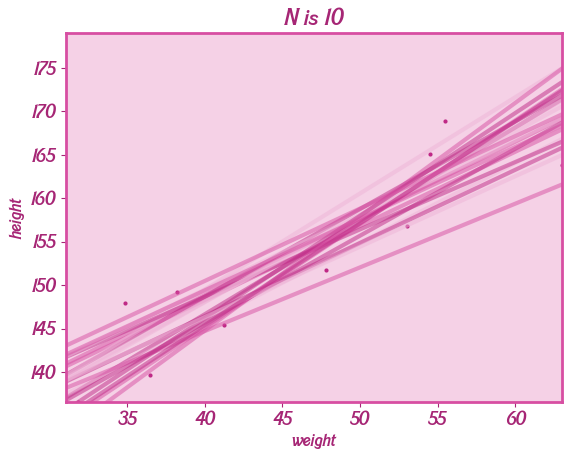

In [63]:
# extract 20 samples from the posterior
post = mN.sample_posterior(random.PRNGKey(1), pN, (20,))

# display raw data and sample size
ax = az.plot_pair(dN[["weight", "height"]].to_dict(orient="list"))
ax.set(
    xlim=(d2.weight.min(), d2.weight.max()),
    ylim=(d2.height.min(), d2.height.max()),
    title="N is {}".format(N),
)

# plot the lines, with transparency
x = jnp.linspace(d2.weight.min(), d2.weight.max(), 101)
for i in range(20):
    plt.plot(x, post["a"][i] + post["b"][i] * (x - dN.weight.mean()), alpha=0.5)

### Code 4.50
We can also make a list of 10k values of µ for an individual who weighs 50 kg.

In [64]:
post = m4_3.sample_posterior(random.PRNGKey(1), p4_3, (1000,))
mu_at_50 = post['a'] + post['b'] * (50 - xbar)

### Code 4.51

Text(0.5, 0, 'mu when weight is 50kg')

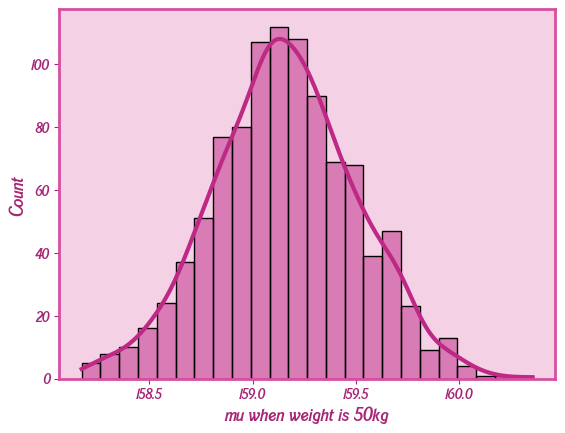

In [65]:
sns.histplot(mu_at_50, kde=True)
plt.xlabel('mu when weight is 50kg')

### Code 4.52

In [66]:
numpyro.diagnostics.hpdi(mu_at_50, 0.89)

array([158.66397, 159.75069], dtype=float32)

### Code 4.53
Now we can sample µ from the initial data:?????

In [67]:
mu = Predictive(m4_3.model, post, return_sites=["mu"])(
    random.PRNGKey(2), d2.weight.values, d2.height.values
)["mu"]
mu.shape, list(mu[:5, 0])

((1000, 352),
 [Array(157.12938, dtype=float32),
  Array(157.30838, dtype=float32),
  Array(157.05736, dtype=float32),
  Array(156.90125, dtype=float32),
  Array(157.4044, dtype=float32)])

### Code 4.54
Let's now compute a distribution of µ for each unique weight value on the horizontal axis:

In [68]:
# define sequence of weights to compute predictions for
# these values will be on the horizontal axis
weight_seq = jnp.arange(start=25, stop=71, step=1)

# use predictive to compute mu
# for each sample from posterior
# and for each weight in weight_seq
mu = Predictive(m4_3.model, post, return_sites=["mu"])(
    random.PRNGKey(2), weight_seq, None
)["mu"]
mu.shape, list(mu[:5, 0])

((1000, 46),
 [Array(134.88252, dtype=float32),
  Array(136.99348, dtype=float32),
  Array(138.36269, dtype=float32),
  Array(137.87814, dtype=float32),
  Array(134.30676, dtype=float32)])

### Code 4.55

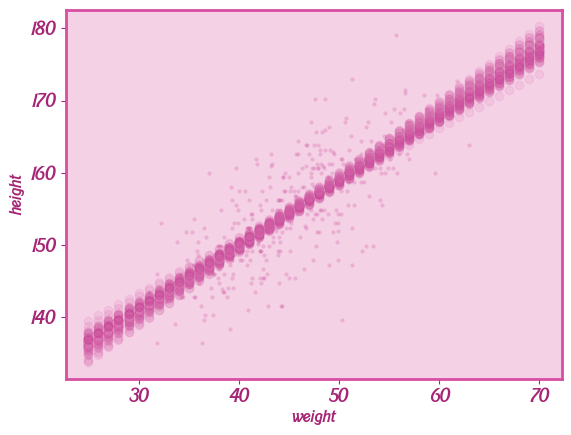

In [69]:
# use scatter_kwargs={"alpha": 0} to hide raw data
az.plot_pair(
    d2[["weight", "height"]].to_dict(orient="list"), scatter_kwargs={"alpha": 0.2}
)

# loop over samples and plot each mu value
for i in range(100):
    plt.plot(weight_seq, mu[i], "o", alpha=0.1)

### Code 4.56
Now we can summarise the distribution of µ for each value:

In [70]:
# summarize the distribution of mu
mu_mean = jnp.mean(mu, 0)
mu_PI = jnp.percentile(mu, q=jnp.array([5.5, 94.5]), axis=0)

### Code 4.57

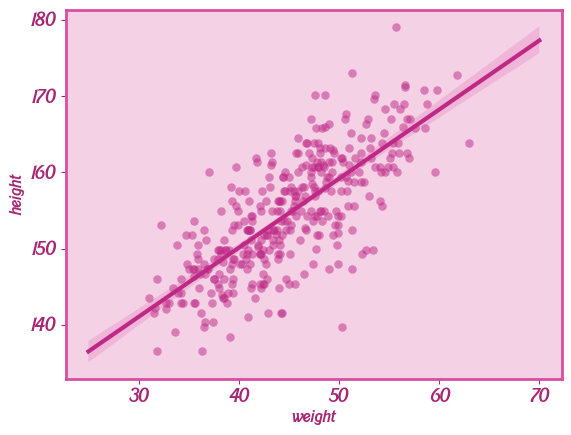

In [71]:
# plot raw data
# fading out points to make line and interval more visible
az.plot_pair(
    d2[["weight", "height"]].to_dict(orient="list"), scatter_kwargs={"alpha": 0.5, "s":150}
)

# plot the MAP line, aka the mean mu for each weight
plt.plot(weight_seq, mu_mean)

# plot a shaded region for 89% PI
plt.fill_between(weight_seq, mu_PI[0], mu_PI[1], alpha=0.2)
plt.show()

### Code 4.58
How Predictive works:

In [72]:
post = m4_3.sample_posterior(random.PRNGKey(1), p4_3, (1000,))
mu_link = lambda weight: post["a"] + post["b"] * (weight - xbar)
weight_seq = jnp.arange(start=25, stop=71, step=1)
mu = vmap(mu_link)(weight_seq).T
mu_mean = jnp.mean(mu, 0)
mu_HPDI = hpdi(mu, prob=0.89, axis=0)

### Code 4.59
Let's now sample the heights:

In [73]:
sim_height = Predictive(m4_3.model, post, return_sites=["height"])(
    random.PRNGKey(2), weight_seq, None
)["height"]
sim_height.shape, list(sim_height[:5, 0])

((1000, 46),
 [Array(135.85771, dtype=float32),
  Array(137.52162, dtype=float32),
  Array(133.89777, dtype=float32),
  Array(138.14607, dtype=float32),
  Array(131.1664, dtype=float32)])

### Code 4.60

In [74]:
height_PI = jnp.percentile(sim_height, q=jnp.array([5.5, 94.5]), axis=0)

### Code 4.61

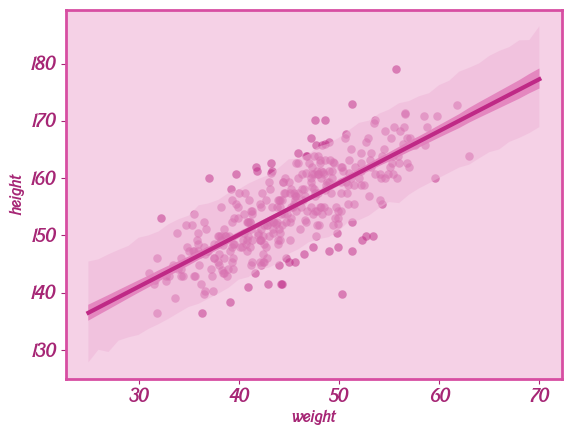

In [75]:
# plot raw data
az.plot_pair(
    d2[["weight", "height"]].to_dict(orient="list"), scatter_kwargs={"alpha": 0.5, "s":150}
)

# draw MAP line
plt.plot(weight_seq, mu_mean)

# draw HPDI region for line
plt.fill_between(weight_seq, mu_HPDI[0], mu_HPDI[1], alpha=0.9)

# draw PI region for simulated heights
plt.fill_between(weight_seq, height_PI[0], height_PI[1], alpha=0.5)
plt.show()

### Code 4.62
To make the shaded interval a bit smoother we can sample more samples:

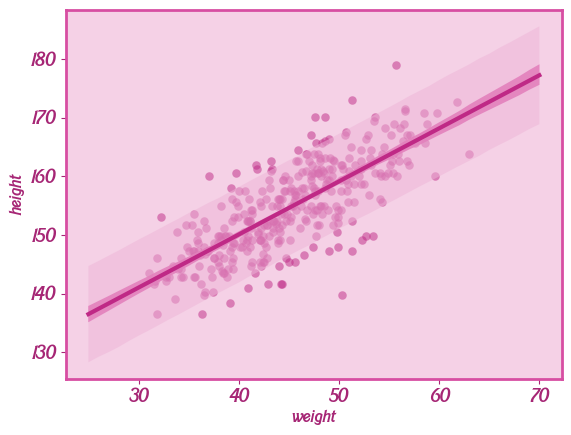

In [76]:
post = m4_3.sample_posterior(random.PRNGKey(1), p4_3, sample_shape=(int(1e5),))
sim_height = Predictive(m4_3.model, post, return_sites=["height"])(
    random.PRNGKey(2), weight_seq, None
)["height"]
height_PI = jnp.percentile(sim_height, q=jnp.array([5.5, 94.5]), axis=0)

# plot raw data
az.plot_pair(
    d2[["weight", "height"]].to_dict(orient="list"), scatter_kwargs={"alpha": 0.5, "s":150}
)

# draw MAP line
plt.plot(weight_seq, mu_mean)

# draw HPDI region for line
plt.fill_between(weight_seq, mu_HPDI[0], mu_HPDI[1], alpha=0.9)

# draw PI region for simulated heights
plt.fill_between(weight_seq, height_PI[0], height_PI[1], alpha=0.5)
plt.show()

### Code 4.63
Can do that manually as well:

In [77]:
post = m4_3.sample_posterior(random.PRNGKey(1), p4_3, (1000,))
weight_seq = jnp.arange(25, 71)
sim_height = vmap(
    lambda i, weight: dist.Normal(
        post["a"] + post["b"] * (weight - xbar), post["sigma"]
    ).sample(random.PRNGKey(i))
)(jnp.arange(len(weight_seq)), weight_seq).T
height_PI = jnp.percentile(sim_height, q=jnp.array([5.5, 94.5]), axis=0)

### Code 4.64
If we look at all ages, the height is not linearly dependent on weight:

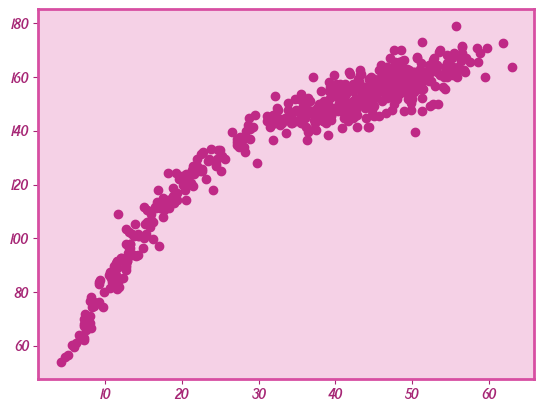

In [78]:
plt.scatter(d.weight, d.height);

### Code 4.65
So we can try developing a polynomial model:
$$h_i \sim Normal(µ_i, σ)$$
$$µ = \alpha + \beta_1x_i + \beta_2x_i^2 $$
$$\alpha \sim Normal(178, 20)$$
$$\beta_1 \sim Log-Normal(0,1)$$
$$\beta_2 \sim Normal(0,1)$$
$$σ \sim Uniform(0,50)$$

In [79]:
d["weight_s"] = (d.weight - d.weight.mean()) / d.weight.std()
d["weight_s2"] = d.weight_s**2


def model(weight_s, weight_s2, height=None):
    a = numpyro.sample("a", dist.Normal(178, 20))
    b1 = numpyro.sample("b1", dist.LogNormal(0, 1))
    b2 = numpyro.sample("b2", dist.Normal(0, 1))
    sigma = numpyro.sample("sigma", dist.Uniform(0, 50))
    mu = numpyro.deterministic("mu", a + b1 * weight_s + b2 * weight_s2)
    numpyro.sample("height", dist.Normal(mu, sigma), obs=height)


m4_5 = AutoLaplaceApproximation(model)
svi = SVI(
    model,
    m4_5,
    optim.Adam(0.3),
    Trace_ELBO(),
    weight_s=d.weight_s.values,
    weight_s2=d.weight_s2.values,
    height=d.height.values,
)
svi_result = svi.run(random.PRNGKey(0), 3000)
p4_5 = svi_result.params

100%|██████████| 3000/3000 [00:00<00:00, 10362.36it/s, init loss: 68267.6406, avg. loss [2851-3000]: 1770.2694]


### Code 4.66

In [80]:
samples = m4_5.sample_posterior(random.PRNGKey(1), p4_5, (1000,))
print_summary({k: v for k, v in samples.items() if k != "mu"}, 0.89, False)


                mean       std    median      5.5%     94.5%     n_eff     r_hat
         a    146.05      0.36    146.03    145.47    146.58   1049.96      1.00
        b1     21.75      0.30     21.75     21.25     22.18    886.88      1.00
        b2     -7.79      0.28     -7.79     -8.21     -7.32   1083.62      1.00
     sigma      5.78      0.17      5.78      5.49      6.02    973.21      1.00



### Code 4.67

In [81]:
weight_seq = jnp.linspace(start=-2.2, stop=2, num=30)
pred_dat = {"weight_s": weight_seq, "weight_s2": weight_seq**2}
post = m4_5.sample_posterior(random.PRNGKey(1), p4_5, (1000,))
predictive = Predictive(m4_5.model, post)
mu = predictive(random.PRNGKey(2), **pred_dat)["mu"]
mu_mean = jnp.mean(mu, 0)
mu_PI = jnp.percentile(mu, q=jnp.array([5.5, 94.5]), axis=0)
sim_height = predictive(random.PRNGKey(3), **pred_dat)["height"]
height_PI = jnp.percentile(sim_height, q=jnp.array([5.5, 94.5]), axis=0)

### Code 4.68

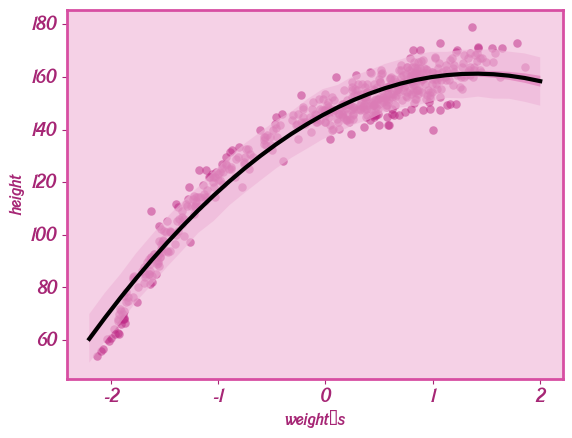

In [82]:
az.plot_pair(
    d[["weight_s", "height"]].to_dict(orient="list"), scatter_kwargs={"alpha": 0.5, "s": 150}
)
plt.plot(weight_seq, mu_mean, "k")
plt.fill_between(weight_seq, mu_PI[0], mu_PI[1],alpha=0.9)
plt.fill_between(weight_seq, height_PI[0], height_PI[1], alpha=0.6)
plt.show()

### Code 4.69
Can also make the model with a higher polynomial order:

In [83]:
d["weight_s3"] = d.weight_s**3


def model(weight_s, weight_s2, weight_s3, height=None):
    a = numpyro.sample("a", dist.Normal(178, 20))
    b1 = numpyro.sample("b1", dist.LogNormal(0, 1))
    b2 = numpyro.sample("b2", dist.Normal(0, 1))
    b3 = numpyro.sample("b3", dist.Normal(0, 1))
    sigma = numpyro.sample("sigma", dist.Uniform(0, 50))
    mu = numpyro.deterministic("mu", a + b1 * weight_s + b2 * weight_s2 + b3 * weight_s3)
    numpyro.sample("height", dist.Normal(mu, sigma), obs=height)


m4_6 = AutoLaplaceApproximation(model)
svi = SVI(
    model,
    m4_6,
    optim.Adam(0.3),
    Trace_ELBO(),
    weight_s=d.weight_s.values,
    weight_s2=d.weight_s2.values,
    weight_s3=d.weight_s3.values,
    height=d.height.values,
)
svi_result = svi.run(random.PRNGKey(0), 1000)
p4_6 = svi_result.params

100%|██████████| 1000/1000 [00:00<00:00, 4375.83it/s, init loss: 5544.0449, avg. loss [951-1000]: 1668.3278]


### Code 4.70

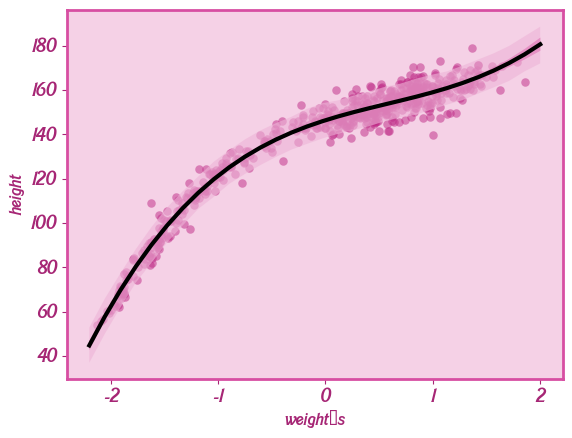

In [84]:
weight_seq = jnp.linspace(start=-2.2, stop=2, num=30)
pred_dat = {"weight_s": weight_seq, "weight_s2": weight_seq**2, "weight_s3": weight_seq**3}
post = m4_6.sample_posterior(random.PRNGKey(1), p4_6, (1000,))
predictive = Predictive(m4_6.model, post)
mu = predictive(random.PRNGKey(2), **pred_dat)["mu"]
mu_mean = jnp.mean(mu, 0)
mu_PI = jnp.percentile(mu, q=jnp.array([5.5, 94.5]), axis=0)
sim_height = predictive(random.PRNGKey(3), **pred_dat)["height"]
height_PI = jnp.percentile(sim_height, q=jnp.array([5.5, 94.5]), axis=0)

az.plot_pair(
    d[["weight_s", "height"]].to_dict(orient="list"), scatter_kwargs={"alpha": 0.5, "s": 150}
)
plt.plot(weight_seq, mu_mean, "k")
plt.fill_between(weight_seq, mu_PI[0], mu_PI[1],alpha=0.9)
plt.fill_between(weight_seq, height_PI[0], height_PI[1], alpha=0.6)
plt.show()

### Code 4.72

In [85]:
d = pd.read_csv("data/cherry_blossoms.csv", sep=';')
print_summary({"year": d.year.dropna().values}, 0.89, False)
print_summary({"doy": d.doy.dropna().values}, 0.89, False)
print_summary({"temp": d.temp.dropna().values}, 0.89, False)
print_summary({"temp_upper": d.temp_upper.dropna().values}, 0.89, False)
print_summary({"temp_lower": d.temp_lower.dropna().values}, 0.89, False)


                mean       std    median      5.5%     94.5%     n_eff     r_hat
      year   1408.00    350.88   1408.00    801.00   1882.00      2.51      2.65


                mean       std    median      5.5%     94.5%     n_eff     r_hat
       doy    104.54      6.41    105.00     93.00    113.00    111.98      1.00


                mean       std    median      5.5%     94.5%     n_eff     r_hat
      temp      6.14      0.66      6.10      5.03      7.13     22.07      1.02


                  mean       std    median      5.5%     94.5%     n_eff     r_hat
  temp_upper      7.19      0.99      7.04      5.66      8.54     10.11      1.24


                  mean       std    median      5.5%     94.5%     n_eff     r_hat
  temp_lower      5.10      0.85      5.14      3.79      6.37     21.90      1.11



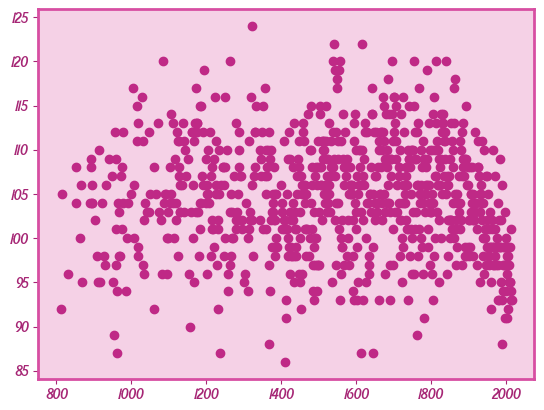

In [86]:
plt.scatter(d.year, d.doy);

### Code 4.73
Let's define the knots for splines:

In [87]:
d2 = d[d.doy.notna()]  # complete cases on doy
num_knots = 15
knot_list = jnp.quantile(
    d2.year.values.astype(float), q=jnp.linspace(0, 1, num=num_knots)
)

### Code 4.74
Now we can construct basis functions from the knots:

In [88]:
knots = jnp.pad(knot_list, (3, 3), mode="edge")
B = BSpline(knots, jnp.identity(num_knots + 2), k=3)(d2.year.values)

### Code 4.75

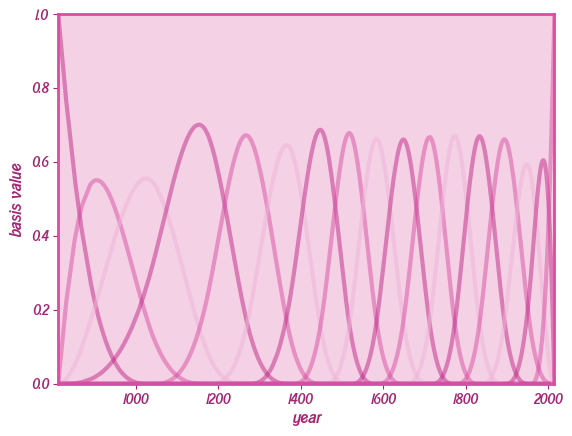

In [89]:
plt.subplot(
    xlim=(d2.year.min(), d2.year.max()),
    ylim=(0, 1),
    xlabel="year",
    ylabel="basis value",
)
for i in range(B.shape[1]):
    plt.plot(d2.year, B[:, i], alpha=0.5)

### Code 4.76
So we can try developing a spline model:
$$D_i \sim Normal(µ_i, σ)$$
$$µ = \alpha + \sum_{k=1}^K w_k B_{k,i}$$
$$\alpha \sim Normal(100, 10)$$
$$w_j \sim Normal(0,10)$$
$$\sigma \sim Exponential(1)$$


In [90]:
def model(B, D):
    a = numpyro.sample("a", dist.Normal(100, 10))
    w = numpyro.sample("w", dist.Normal(0, 10).expand(B.shape[1:]))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = numpyro.deterministic("mu", a + B @ w)
    numpyro.sample("D", dist.Normal(mu, sigma), obs=D)


start = {"w": jnp.zeros(B.shape[1])}
m4_7 = AutoLaplaceApproximation(model, init_loc_fn=init_to_value(values=start))
svi = SVI(model, m4_7, optim.Adam(1), Trace_ELBO(), B=B, D=d2.doy.values)
svi_result = svi.run(random.PRNGKey(0), 20000)
p4_7 = svi_result.params

100%|██████████| 20000/20000 [00:01<00:00, 18803.39it/s, init loss: 2476234.7500, avg. loss [19001-20000]: 2705.3284]


### Code 4.77
Let's sample posterior basis functions:

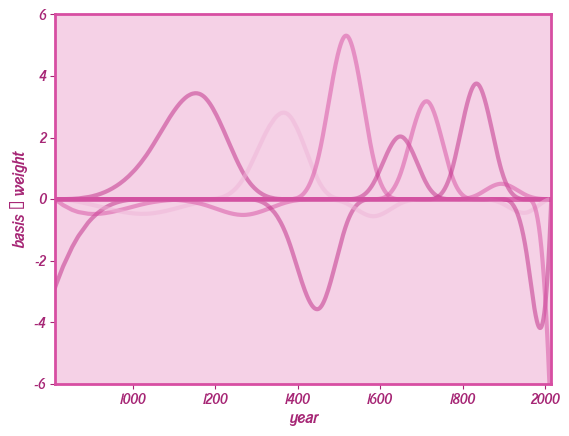

In [91]:
post = m4_7.sample_posterior(random.PRNGKey(1), p4_7, (1000,))
w = jnp.mean(post["w"], 0)
plt.subplot(
    xlim=(d2.year.min(), d2.year.max()),
    ylim=(-6, 6),
    xlabel="year",
    ylabel="basis * weight",
)
for i in range(B.shape[1]):
    plt.plot(d2.year, (w[i] * B[:, i]), alpha=0.5)

### Code 4.78
And, finally, a posterior 97% for µ:

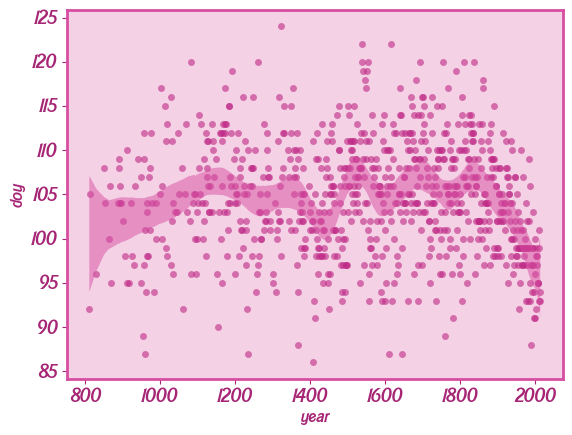

In [92]:
mu = post["mu"]
mu_PI = jnp.percentile(mu, q=jnp.array([1.5, 98.5]), axis=0)
az.plot_pair(
    d2[["year", "doy"]].astype(float).to_dict(orient="list"),
    scatter_kwargs={"alpha": 0.6, "s": 100},
)
plt.fill_between(d2.year, mu_PI[0], mu_PI[1], alpha=0.5)
plt.show()

## Homework

### 4M1

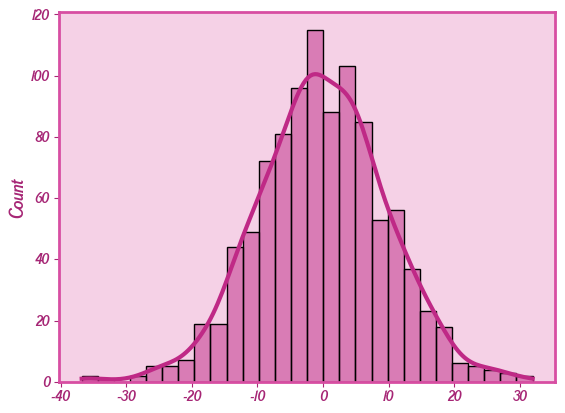

In [93]:
mu = dist.Normal(0, 10).sample(random.PRNGKey(0), (1000,))
sigma = dist.Exponential(1).sample(random.PRNGKey(1), (1000,))
y_i = dist.Normal(mu, sigma).sample(random.PRNGKey(2))

sns.histplot(y_i, kde=True);

### 4M2

In [94]:
def model(height):
    mu = numpyro.sample("mu", dist.Normal(0, 10))                 # same as dist.Distribution().sample()?
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    numpyro.sample("height", dist.Normal(mu, sigma), obs=height)    # whats happening here? we sample from N(µ, σ), why obs?

### 4M7

In [95]:
d = pd.read_csv('data/Howell1.csv', sep=';')
d2 = d.loc[d['age'] >= 18,]

def model(weight, height):
    a = numpyro.sample("a", dist.Normal(178, 20))
    b = numpyro.sample("b", dist.LogNormal(0, 1))
    sigma = numpyro.sample("sigma", dist.Uniform(0, 50))
    mu = numpyro.deterministic("mu", a + b * weight)
    numpyro.sample("height", dist.Normal(mu, sigma), obs=height)    
    
m4m_7 = AutoLaplaceApproximation(model)
svi = SVI(
    model, 
    m4m_7, 
    optim.Adam(1), 
    Trace_ELBO(), 
    weight=d2.weight.values, 
    height=d2.height.values
    ) 
svi_result = svi.run(random.PRNGKey(0), 2000)
p4m_7 = svi_result.params
samples = m4m_7.sample_posterior(random.PRNGKey(1), p4m_7, (1000,))
samples.pop("mu")
print_summary(samples, 0.89, False)

#        mean        std       median    5.5%      94.5%     n_eff       r_hat
# a      154.62      0.27      154.63    154.16    155.03    931.50      1.00
# b      0.91        0.04      0.90      0.84      0.97      1083.74     1.00
# sigma  5.08        0.19      5.08      4.79      5.41      949.65      1.00

  0%|          | 0/2000 [00:00<?, ?it/s]

100%|██████████| 2000/2000 [00:00<00:00, 8228.63it/s, init loss: 21101.8516, avg. loss [1901-2000]: 1083.3383]



                mean       std    median      5.5%     94.5%     n_eff     r_hat
         a    114.57      1.92    114.64    111.39    117.45    931.50      1.00
         b      0.89      0.04      0.89      0.82      0.95    937.67      1.00
     sigma      5.09      0.19      5.08      4.79      5.42    949.65      1.00



In [99]:
vcov = jnp.cov(jnp.stack(list(samples.values()), axis=0))
pd.DataFrame(jnp.round(vcov, 3), columns=['a', 'b', 'sigma'], index=['a', 'b', 'sigma'])

# 	    a	    b	    sigma
# a	    0.075	-0.000	0.001
# b	    -0.000	0.002	-0.000
# sigma	0.001	-0.000	0.038

,a,b,sigma
a,3.694,-0.081,0.017
b,-0.081,0.002,-0.000
sigma,0.017,-0.000,0.038


<Axes: xlabel='weight', ylabel='height'>

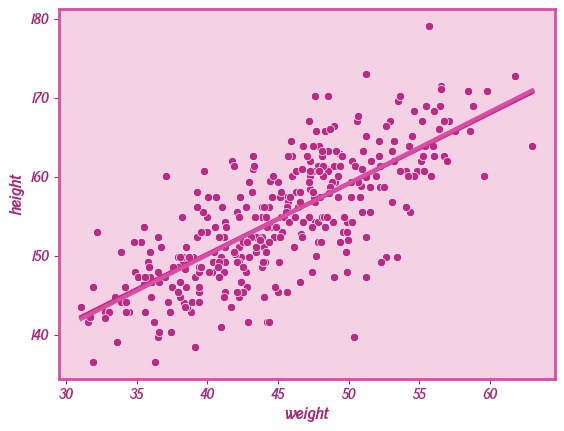

In [98]:
sns.scatterplot(x=d2.weight, y=d2.height)
post = m4m_7.sample_posterior(random.PRNGKey(1), p4m_7, (1000,))
a_map = post['a'].mean()
b_map = post['b'].mean()
x = jnp.linspace(d2.weight.min(), d2.weight.max(), 101)
sns.lineplot(x=x, y=a_map + b_map * x)

post = m4_3.sample_posterior(random.PRNGKey(1), p4_3, (1000,))
a_map = post['a'].mean()
b_map = post['b'].mean()
x = jnp.linspace(d2.weight.min(), d2.weight.max(), 101)
sns.lineplot(x=x, y=a_map + b_map * (x - xbar))

### 4M8

100%|██████████| 20000/20000 [00:01<00:00, 14270.93it/s, init loss: 2476331.5000, avg. loss [19001-20000]: 2785.4045]


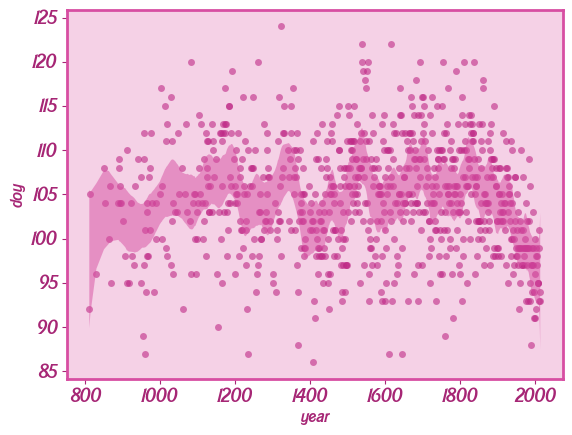

In [101]:
d = pd.read_csv("data/cherry_blossoms.csv", sep=';')
d2 = d[d.doy.notna()]  # complete cases on doy

num_knots = 45
knot_list = jnp.quantile(
    d2.year.values.astype(float), q=jnp.linspace(0, 1, num=num_knots)
)
knots = jnp.pad(knot_list, (3, 3), mode="edge")
B = BSpline(knots, jnp.identity(num_knots + 2), k=3)(d2.year.values)

def model(B, D):
    a = numpyro.sample("a", dist.Normal(100, 10))
    w = numpyro.sample("w", dist.Normal(0, 10).expand(B.shape[1:]))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = numpyro.deterministic("mu", a + B @ w)
    numpyro.sample("D", dist.Normal(mu, sigma), obs=D)


start = {"w": jnp.zeros(B.shape[1])}
m4m_8 = AutoLaplaceApproximation(model, init_loc_fn=init_to_value(values=start))
svi = SVI(model, m4m_8, optim.Adam(1), Trace_ELBO(), B=B, D=d2.doy.values)
svi_result = svi.run(random.PRNGKey(0), 20000)
p4m_8 = svi_result.params

post = m4m_8.sample_posterior(random.PRNGKey(1), p4m_8, (1000,)) 
mu = post["mu"]
mu_PI = jnp.percentile(mu, q=jnp.array([1.5, 98.5]), axis=0)
az.plot_pair(
    d2[["year", "doy"]].astype(float).to_dict(orient="list"),
    scatter_kwargs={"alpha": 0.6, "s": 100},
)
plt.fill_between(d2.year, mu_PI[0], mu_PI[1], alpha=0.5)
plt.show()


  0%|          | 0/20000 [00:00<?, ?it/s]

100%|██████████| 20000/20000 [00:01<00:00, 18271.95it/s, init loss: 2476195.5000, avg. loss [19001-20000]: 2709.5442]


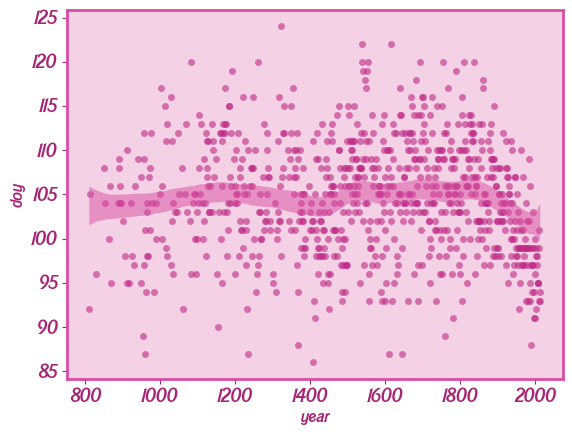

In [103]:
num_knots = 15
knot_list = jnp.quantile(
    d2.year.values.astype(float), q=jnp.linspace(0, 1, num=num_knots)
)
knots = jnp.pad(knot_list, (3, 3), mode="edge")
B = BSpline(knots, jnp.identity(num_knots + 2), k=3)(d2.year.values)

def model(B, D):
    a = numpyro.sample("a", dist.Normal(100, 10))
    w = numpyro.sample("w", dist.Normal(0, 1).expand(B.shape[1:]))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = numpyro.deterministic("mu", a + B @ w)
    numpyro.sample("D", dist.Normal(mu, sigma), obs=D)


start = {"w": jnp.zeros(B.shape[1])}
m4m_8 = AutoLaplaceApproximation(model, init_loc_fn=init_to_value(values=start))
svi = SVI(model, m4m_8, optim.Adam(1), Trace_ELBO(), B=B, D=d2.doy.values)
svi_result = svi.run(random.PRNGKey(0), 20000)
p4m_8 = svi_result.params

post = m4m_8.sample_posterior(random.PRNGKey(1), p4m_8, (1000,)) 
mu = post["mu"]
mu_PI = jnp.percentile(mu, q=jnp.array([1.5, 98.5]), axis=0)
az.plot_pair(
    d2[["year", "doy"]].astype(float).to_dict(orient="list"),
    scatter_kwargs={"alpha": 0.6, "s": 100},
)
plt.fill_between(d2.year, mu_PI[0], mu_PI[1], alpha=0.5)
plt.show()


### 4H1
>The weights listed below were recorded in the !Kung census, but heights were not recorded for the weights 45, 40, 65, 31 and 53. Provide predicted heights and 89% compatibility intervals for each of these individuals. That is, fill in the table below, using model-based predictions.

In [108]:
d = pd.read_csv('data/Howell1.csv', sep=';', header=0)
d1 = d.loc[d.age>=18].reset_index(drop=True)
d.head()


,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


In [128]:
aux = (pd.DataFrame(np.array([46.95, 43.72, 64.78, 32.59, 54.63]))
       .rename(columns={0:'weight'})
       .assign(expected_height=np.nan)
       .assign(pct_89_interval=np.nan)
      )
aux

,weight,expected_height,pct_89_interval
0,46.95,NaN,NaN
1,43.72,NaN,NaN
2,64.78,NaN,NaN
3,32.59,NaN,NaN
4,54.63,NaN,NaN


In [134]:
post = m4_3.sample_posterior(random.PRNGKey(1), p4_3, (1000,))
sim_height = Predictive(m4_3.model, post, return_sites=["height"])(
    random.PRNGKey(2), aux.weight.values, None
)["height"]
aux['expected_height'] = sim_height.mean(axis=0)
pi_height = hpdi(sim_height, prob=0.89, axis=0)
aux.pct_89_interval = [f'{pi_height[0, i]:.2f}-{pi_height[1, i]:.2f}' for i in range(len(pi_height[0]))]
aux


,weight,expected_height,pct_89_interval
0,46.95,156.605209,148.70-164.81
1,43.72,153.593552,146.38-162.58
2,64.78,172.579880,164.20-180.67
3,32.59,143.433151,134.34-150.49
4,54.63,163.223877,154.72-170.80


### 4H2

<Axes: xlabel='weight', ylabel='height'>

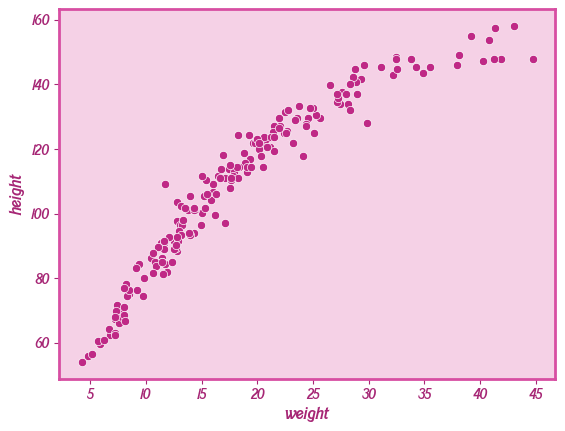

In [137]:
d4h2 = d[d.age < 18]

sns.scatterplot(x=d4h2.weight, y=d4h2.height)

In [147]:
d4h2["weight_s"] = (d4h2.weight - d4h2.weight.mean()) / d4h2.weight.std()


def model(weight_s, height=None):
    a = numpyro.sample("a", dist.Normal(140, 20))
    b = numpyro.sample("b", dist.LogNormal(0, 1))
    sigma = numpyro.sample("sigma", dist.Uniform(0, 50))
    mu = numpyro.deterministic("mu", a + b * weight_s)
    numpyro.sample("height", dist.Normal(mu, sigma), obs=height)


m4h_2 = AutoLaplaceApproximation(model)
svi = SVI(
    model,
    m4h_2,
    optim.Adam(0.3),
    Trace_ELBO(),
    weight_s=d4h2.weight_s.values,
    height=d4h2.height.values,
)
svi_result = svi.run(random.PRNGKey(0), 3000)
p4h_2 = svi_result.params

100%|██████████| 3000/3000 [00:00<00:00, 9711.18it/s, init loss: 11126.5195, avg. loss [2851-3000]: 695.0410] 


In [148]:
samples = m4h_2.sample_posterior(random.PRNGKey(1), p4h_2, (1000,))
samples.pop("mu")
print_summary(samples, 0.89, False)


                mean       std    median      5.5%     94.5%     n_eff     r_hat
         a    108.39      0.62    108.41    107.36    109.31    931.50      1.00
         b     24.27      0.62     24.25     23.36     25.35   1095.93      1.00
     sigma      8.47      0.44      8.47      7.81      9.21    948.34      1.00



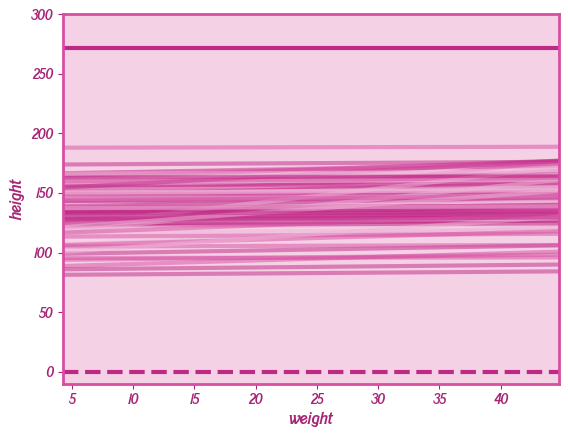

In [154]:
with numpyro.handlers.seed(rng_seed=2971):
    N = 100  # 100 lines
    a = numpyro.sample("a", dist.Normal(140, 20).expand([N]))
    b = numpyro.sample("b", dist.LogNormal(0, 1).expand([N]))
    
plt.subplot(
    xlim=(d4h2.weight.min(), d4h2.weight.max()),
    ylim=(-10, 300),
    xlabel="weight",
    ylabel="height",
)
plt.axhline(y=0, ls="--")
plt.axhline(y=272, ls="-")
xbar = d4h2.weight.mean()
xstd = d4h2.weight.std()
x = jnp.linspace(d4h2.weight.min(), d4h2.weight.max(), 101)
for i in range(N):
    plt.plot(x, a[i] + b[i] * (x - xbar)/xstd, alpha=0.5)
plt.show()

In [168]:
height_PI.shape

(2, 46)

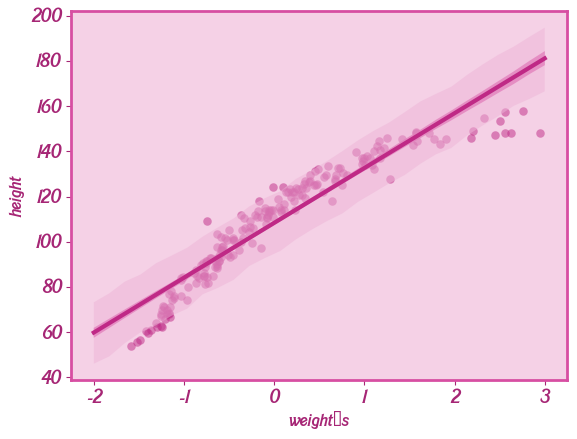

In [175]:
weight_seq = jnp.linspace(start=-2, stop=3, num=30)

post = m4h_2.sample_posterior(random.PRNGKey(1), p4h_2, (1000,))
mu = Predictive(m4h_2.model, post, return_sites=["mu"])(
    random.PRNGKey(2), weight_seq, None
)["mu"]
mu_mean = jnp.mean(mu, 0)
mu_PI = numpyro.diagnostics.hpdi(mu, 0.89, axis=0)

sim_height = Predictive(m4h_2.model, post, return_sites=["height"])(
    random.PRNGKey(2), weight_seq, None
)["height"]
height_PI = numpyro.diagnostics.hpdi(sim_height, 0.89, axis=0)

az.plot_pair(
    d4h2[["weight_s", "height"]].to_dict(orient="list"), scatter_kwargs={"alpha": 0.5, "s":150}
)

plt.plot(weight_seq, mu_mean)
plt.fill_between(weight_seq, mu_PI[0], mu_PI[1], alpha=0.8)
plt.fill_between(weight_seq, height_PI[0], height_PI[1], alpha=0.5)

plt.show()

>Model the relationship between `height` (cm) and the natural logarithm of weight (log-kg): `log(weight)`. Use the entire `Howell1` data frame, all 544 rows, adults and non-adults. Use any model type from Chapter 4 (from the book) that you think useful: an ordinary linear regression, a polynomial or a spline. Plot the posterior predictions against the raw data.

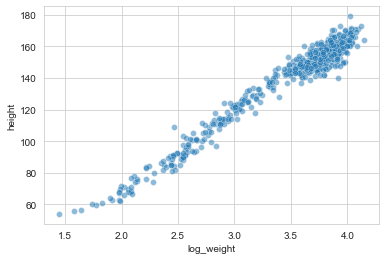

In [19]:
d2 = d.assign(log_weight = np.log(d.weight))
g = sns.scatterplot(data=d2, x='log_weight', y='height', alpha=0.5)

In [20]:
def model(weight, height=None):
    # priors
    alpha = numpyro.sample('alpha', dist.Normal(178,20))
    beta = numpyro.sample('beta', dist.Normal(0,1))
    sigma = numpyro.sample('sigma', dist.Normal(0,50))
    # likelihood
    mu = alpha + beta*weight
    numpyro.sample('height_hat', dist.Normal(mu,sigma), obs=height)

In [21]:
kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup=500, num_samples=500, num_chains=4, chain_method='sequential')
mcmc.run(rng_key, weight=d2.log_weight.values, height=d2.height.values)
mcmc.print_summary()

sample: 100%|██████████| 1000/1000 [00:02<00:00, 459.37it/s, 15 steps of size 1.19e-01. acc. prob=0.95]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha     87.47      4.38     87.25     80.02     94.65    474.59      1.01
      beta     14.80      1.24     14.85     12.76     16.85    477.18      1.01
     sigma     19.34      0.92     19.28     17.89     20.91    483.59      1.01

Number of divergences: 0


Let's get traces using both `az`.

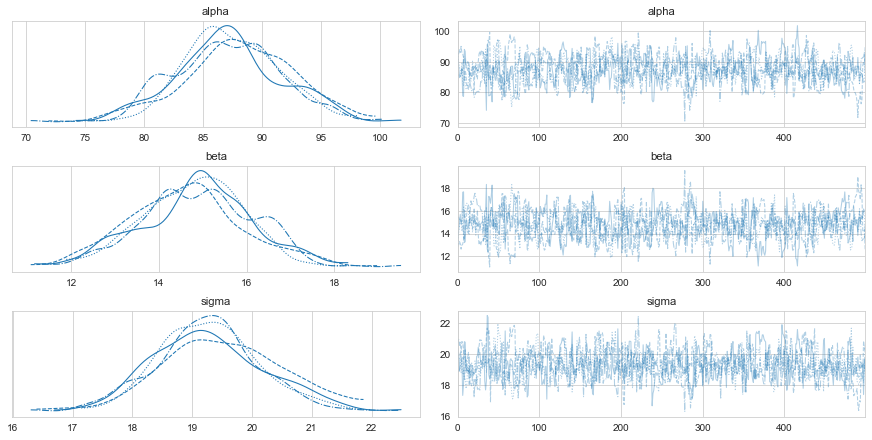

In [22]:
prior = Predictive(model, num_samples=500)(rng_key, weight=d2.log_weight.values)
posterior = mcmc.get_samples()
posterior_pred = Predictive(model, posterior)(rng_key, weight=d2.log_weight.values)
samples = az.from_numpyro(mcmc, posterior_predictive=posterior_pred)
az.plot_trace(samples);

Just as the previous exercise, we recover the mean of height_hat for each sample and the High Posterior Density interval for each sample as well.

In [23]:
d21 = d2.assign(height_hat=posterior_pred['height_hat']._value.mean(axis=0))
hpdi = [az.hdi(s) for s in posterior_pred['height_hat']._value.T]
hpdi = pd.DataFrame(hpdi).rename({0:'lower_hpdi',1:'upper_hpdi'}, axis=1)
d21 = pd.concat([d21, hpdi], axis=1).sort_values(by=['weight'])

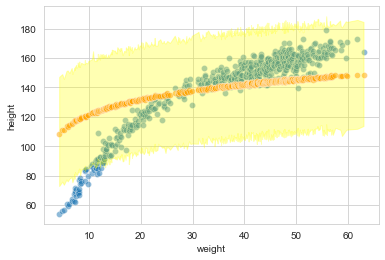

In [24]:
g = sns.scatterplot(data=d21, x='weight', y='height', alpha=0.5)
g.fill_between(d21.weight, d21.lower_hpdi, d21.upper_hpdi, color='yellow', alpha=0.3)
sns.scatterplot(data=d21, x='weight', y='height_hat', color='orange', alpha=0.5);

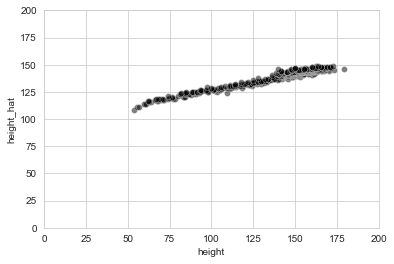

In [25]:
g = sns.scatterplot(data=d21, x='height', y='height_hat', color='black', alpha=0.5)
g.set(xlim=(0,200), ylim=(0,200));

Results are meh. Let's see what happens when we take a polynomial regression of second degree.

In [26]:
d2 = d.assign(weight_2=d2.weight**2)
d2.head(3)

,height,weight,age,male,weight_2
0,151.765,47.825606,63.0,1,2287.288637
1,139.700,36.485807,63.0,0,1331.214076
2,136.525,31.864838,65.0,0,1015.367901


In [27]:
def model(weight, height=None):
    # priors
    alpha = numpyro.sample('alpha', dist.Normal(178,20))
    beta1 = numpyro.sample('beta1', dist.Normal(0,1))
    beta2 = numpyro.sample('beta2', dist.Normal(0,1))
    sigma = numpyro.sample('sigma', dist.Normal(0,50))
    # likelihood
    mu = alpha + beta1*weight + beta2*(weight**2)
    numpyro.sample('height_hat', dist.Normal(mu,sigma), obs=height)

In [28]:
kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup=500, num_samples=500, num_chains=4, chain_method='sequential')
mcmc.run(rng_key, weight=d2.weight.values, height=d2.height.values)
mcmc.print_summary()

sample: 100%|██████████| 1000/1000 [00:02<00:00, 429.34it/s, 119 steps of size 1.82e-02. acc. prob=0.89]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha     46.51      1.21     46.51     44.46     48.36    240.61      1.01
     beta1      4.16      0.09      4.15      4.00      4.28    255.38      1.02
     beta2     -0.04      0.00     -0.04     -0.04     -0.04    287.89      1.02
     sigma      5.79      0.18      5.79      5.52      6.09   1100.46      1.00

Number of divergences: 0


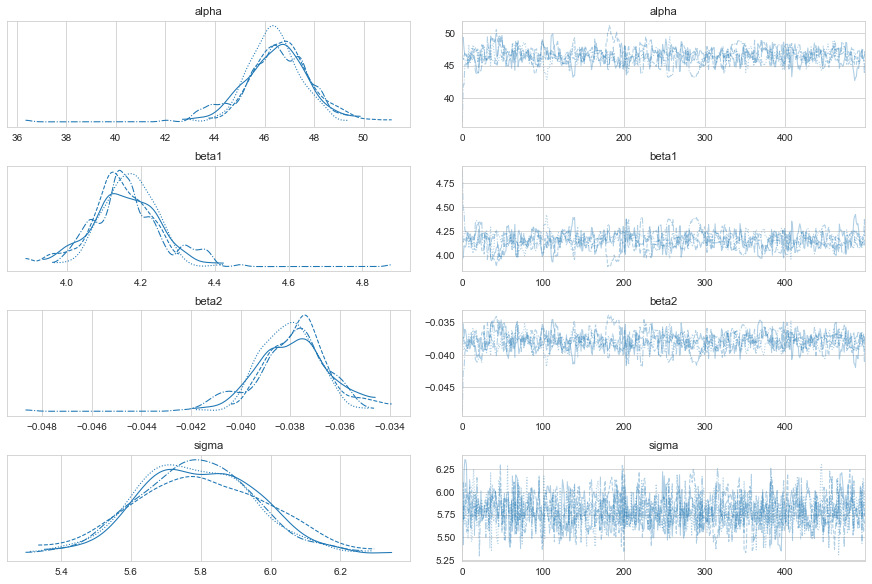

In [29]:
prior = Predictive(model, num_samples=500)(rng_key, weight=d2.weight.values)
posterior = mcmc.get_samples()
posterior_pred = Predictive(model, posterior)(rng_key, weight=d2.weight.values)
samples = az.from_numpyro(mcmc, prior=prior, posterior_predictive=posterior_pred)
az.plot_trace(samples);

In [30]:
d22 = d2.assign(height_hat=posterior_pred['height_hat']._value.mean(axis=0))
hpdi = [az.hdi(s) for s in posterior_pred['height_hat']._value.T]
hpdi = pd.DataFrame(hpdi).rename({0:'lower_hpdi',1:'upper_hpdi'}, axis=1)
d22 = pd.concat([d22, hpdi], axis=1).sort_values(by=['weight'])

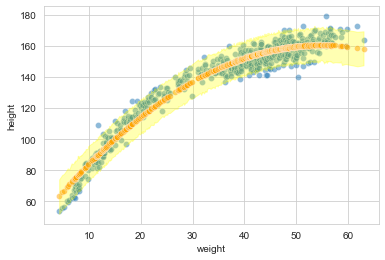

In [31]:
g = sns.scatterplot(data=d22, x='weight', y='height', alpha=0.5)
g.fill_between(d22.weight, d22.lower_hpdi, d22.upper_hpdi, color='yellow', alpha=0.3)
sns.scatterplot(data=d22, x='weight', y='height_hat', color='orange', alpha=0.5);

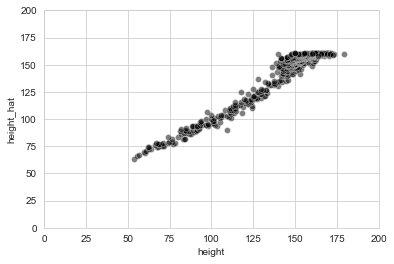

In [32]:
g = sns.scatterplot(data=d22, x='height', y='height_hat', color='black', alpha=0.5)
g.set(xlim=(0,200), ylim=(0,200));

Much better now.

## Exercise 3

> Plot the prior predictive distribution for the polynomial regression model in Chapter 4 (_just what we did in the previous exercise_). You can modify the the code that plots the linear regression prior predictive distribution. 20 or 30 parabolas from the prior should suffice to show where the prior probability resides. Can you modify the prior distributions of `alpha`, `beta1`, and `beta2` so that the prior predictions stay within the biologically reasonable outcome space? That is to say: Do not try to fit the data by hand. But do try to keep the curves consistent with what you know about height and weight, before seeing these exact data.

In [33]:
# taking data from previous section
d3 = d22
prior31 = prior

Let's just recover the values from the priors manually and build a pandas dataframe.

In [34]:
df = pd.DataFrame()
df = df.assign(height_hat = prior31['height_hat'].mean(axis=1),
               alpha = prior31['alpha'],
               sigma = prior31['sigma'],
               beta1 = prior31['beta1'],
               beta2 = prior31['beta2']
               )
df.head()

,height_hat,alpha,sigma,beta1,beta2
0,-307.154053,176.774063,-9.700806,-0.220740,-0.320860
1,-1407.233032,205.809219,31.884762,-1.843794,-1.042232
2,225.267273,166.899307,33.320087,0.745229,0.021352
3,-1422.809326,157.829819,-65.854927,-1.130443,-1.039238
4,-1771.628784,179.733871,23.137325,0.008882,-1.314785


In [35]:
df.mean() # it checks out with the az.summary results

height_hat    109.950752
alpha         176.028534
sigma           0.565620
beta1          -0.103036
beta2          -0.042002
dtype: float32

Now some data wrangling.

In [36]:
priors = pd.DataFrame()
for i in range(30): # 30 parabolas is fine
    priors['prior_'+str(i)] = df.loc[i,'alpha'] + df.loc[i,'beta1'] * d3['weight'] + df.loc[i,'beta2'] * d3['weight_2']

aux = pd.concat([d3.weight, priors], axis=1)
aux_plot = aux.melt(id_vars=['weight'],
                  value_vars=list(aux.columns)[1:],
                  var_name='prior',
                  value_name='height')

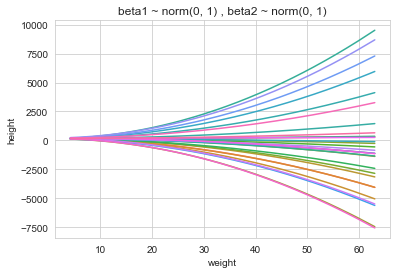

In [37]:
g = sns.lineplot(data=aux_plot, x='weight', y='height', hue='prior', ci=None, legend=False)
g.set(title='beta1 ~ norm(0, 1) , beta2 ~ norm(0, 1)');

Recall that the world's tallest person was 270 cm tall. The prior curvature has silly shapes. That can't be right. The basic problem is that `beta2` needs to be negative to make the curve bend down, but `beta1` has to also change in order to move the maximum height to the right. It's all a bit confusing, and is they key reason that working with polynomial models is so hard. The prior on the right below can only bend down, but I've made the linear model `a + beta1 * weight_c - beta2 * weight_c_2` and given `beta2` a logNormal prior.

In [38]:
d3 = d
d3 = d3.assign(weight_c=pd.Series(d3.weight - d3.weight.mean())/d3.weight.std())
d3 = d3.assign(weight_c_2=pd.Series(d3.weight_c**2))

In [39]:
def model(weight, height=None):
    # priors
    alpha = numpyro.sample('alpha', dist.Normal(178,20))
    beta1 = numpyro.sample('beta1', dist.LogNormal(2,1))
    beta2 = numpyro.sample('beta2', dist.LogNormal(1,1))
    sigma = numpyro.sample('sigma', dist.Normal(0,50))
    # likelihood
    mu = alpha + beta1*weight - beta2*(weight**2)
    numpyro.sample('height_hat', dist.Normal(mu,sigma), obs=height)

In [40]:
kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup=500, num_samples=500, num_chains=4, chain_method='sequential')
mcmc.run(rng_key, weight=d3.weight_c.values, height=d3.height.values)
mcmc.print_summary()

sample: 100%|██████████| 1000/1000 [00:02<00:00, 420.64it/s, 7 steps of size 4.57e-01. acc. prob=0.92]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha    146.67      0.37    146.67    146.09    147.31   1088.09      1.00
     beta1     21.40      0.29     21.40     20.92     21.84   1101.92      1.00
     beta2      8.41      0.28      8.41      7.95      8.83    940.05      1.00
     sigma      5.78      0.17      5.78      5.50      6.05   1487.56      1.00

Number of divergences: 0


In [41]:
prior32 = Predictive(model, num_samples=500)(rng_key, weight=d3.weight_c.values)
df = pd.DataFrame()
df = df.assign(height_hat = prior32['height_hat'].mean(axis=1),
               alpha = prior32['alpha'],
               sigma = prior32['sigma'],
               beta1 = prior32['beta1'],
               beta2 = prior32['beta2']
               )
df.head()

,height_hat,alpha,sigma,beta1,beta2
0,175.013138,176.774063,-9.700806,5.925468,1.972182
1,204.528397,205.809219,31.884762,1.169068,0.958647
2,164.262878,166.899307,33.320087,15.568175,2.776947
3,159.103073,157.829819,-65.854927,2.385855,0.961522
4,178.956604,179.733871,23.137325,7.454978,0.729946


In [42]:
priors = pd.DataFrame()
for i in range(30): # 30 parabolas is fine
    priors['prior_'+str(i)] = df.loc[i,'alpha'] + df.loc[i,'beta1'] * d3['weight_c'] - df.loc[i,'beta2'] * d3['weight_c']

aux = pd.concat([d3.weight, priors], axis=1)
aux_plot = aux.melt(id_vars=['weight'],
                  value_vars=list(aux.columns)[1:],
                  var_name='prior',
                  value_name='height')

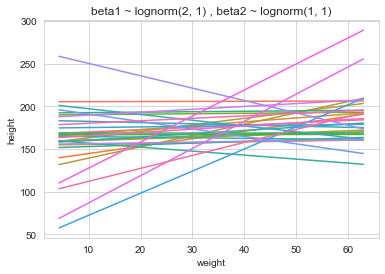

In [43]:
g = sns.lineplot(data=aux_plot, x='weight', y='height', hue='prior', ci=None, legend=False)
g.set(title='beta1 ~ lognorm(2, 1) , beta2 ~ lognorm(1, 1)');

A key problem in getting reasonable curves here is that obviously a and `beta1` and `beta2` are correlated in the family of reasonable curves. But the priors are uncorrelated, they are independent of one another. Still, if you can get independent priors to at least live within some reasonably space of outcome values, that's a lot better than flat priors. This is a general phenomenon with “flat” priors: Once the predictor is at all complicated, “flat” does not imply “no relationship.” Do any of the priors above make a difference for inference in this sample? No. There is a lot of data and the model is quite simple, in terms of the way that parameters relate to predictions. This will not always be the case.